## Technical Problem Presentation

The business partner has two primary objectives to get from this analysis:
1.	Obtain a model that will estimate shipping cost (column “Cost”) for new selections of input variables.  Assume we could change route class and priority if desired.  The data provided includes all possible shipment origins but not all future shipment destinations as we regularly get new customers.
2.	Determine if there are any outliers in the historical data suggesting a higher-than-expected shipping cost that would warrant a follow-up with transportation suppliers regarding their rates.
 
Create a model of cost that you feel captures most of the signal present in the dataset and rejects most of the noise.  See below on how to obtain the data.  As a check, the dataset should be comprised of 306 rows and 8 columns.  

<b>Notebook has following sections:<b>

1- Data understanding and exploration 

2- Data cleaning

3- Data preparation: Feature Engineering and Scaling

4- Feature Selection using RFE and Model Building  

5- Linear Regression Assumptions Validation and Outlier Removal

6- Rebuilding the Model Post Outlier Removal: Feature Selection using K-Fold Cross Validation & RFE  


In [463]:
#Importing requried packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn import metrics
from sklearn import preprocessing

In [464]:
import pandas as pd
df=pd.read_csv("https://raw.githubusercontent.com/bmewing/technical_assessment/master/data.csv")
df.head()

,Origin City,Origin State,Destination City,Destination State,Route Class,Priority,Distance,Cost
0,ANNISTON,AL,BAYPORT,TX,Red,1,808,3105.12
1,ANNISTON,AL,HOUSTON,TX,Green,1,779,3357.28
2,MAGNESS,AR,KINGSPORT,TN,Green,2,657,2670.23
3,MAGNESS,AR,BAYPORT,TX,Red,1,610,2715.14
4,VERNON,CA,HARPERTOWN,CA,Red,1,235,2241.49


In [465]:
df.shape

(306, 8)

In [466]:
df.dtypes

Origin City           object
Origin State          object
Destination City      object
Destination State     object
Route Class           object
Priority               int64
Distance               int64
Cost                 float64
dtype: object

In [467]:
df.describe()

,Priority,Distance,Cost
count,306.000000,306.000000,306.000000
mean,1.196078,960.526144,3226.464771
std,0.715714,639.685113,1429.989144
min,1.000000,9.000000,683.620000
25%,1.000000,452.250000,2169.320000
50%,1.000000,835.000000,3004.175000
75%,1.000000,1264.750000,3938.597500
max,10.000000,3247.000000,8265.170000


## Missing Values

In [468]:
df.isnull().values.any()

False

In [469]:
df.isnull().sum()
## No missing values in the dataset

Origin City          0
Origin State         0
Destination City     0
Destination State    0
Route Class          0
Priority             0
Distance             0
Cost                 0
dtype: int64

In [470]:
(df.select_dtypes(include=['int64'])).columns

Index(['Priority', 'Distance'], dtype='object')

## EDA

## Numerical variables

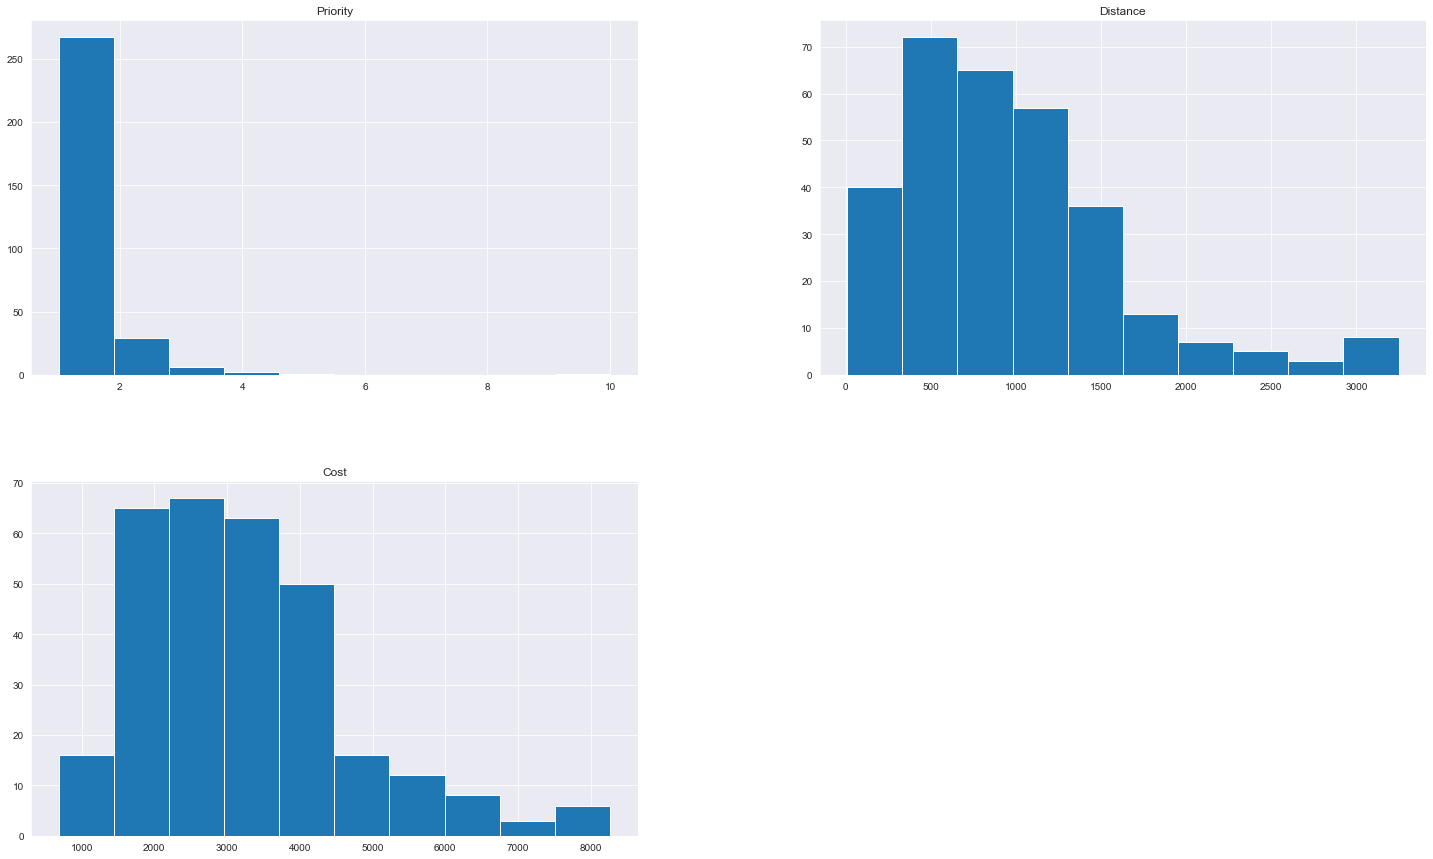

In [471]:
#Exploring histograms of numerical columns 
df.hist(bins=10, figsize=(25,15))
plt.show()

C:\Users\v_v\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


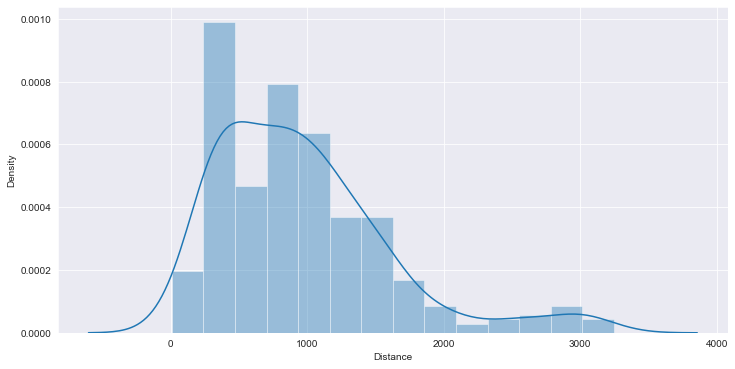

In [472]:
# Distance: distance travalled by ship from to Origin to Destination
sns.distplot(df['Distance'])
plt.show()

C:\Users\v_v\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


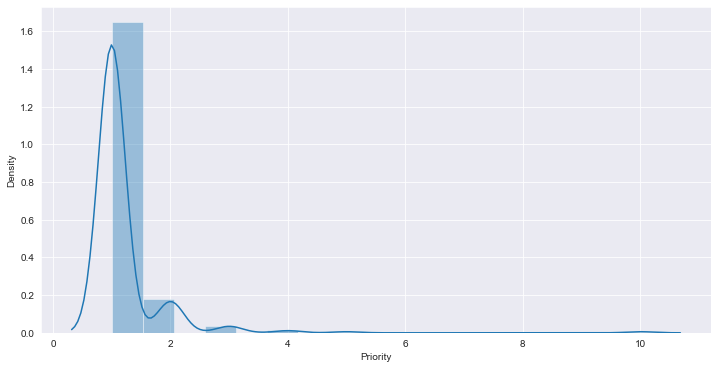

In [473]:
sns.distplot(df['Priority'])
plt.show()

In [474]:
df['Priority'].value_counts()

1     267
2      29
3       6
4       2
10      1
5       1
Name: Priority, dtype: int64

In [475]:
#it is good to change Priority column from int to object?
#df['Priority']=df['Priority'].astype('object')

In [476]:
df.dtypes

Origin City           object
Origin State          object
Destination City      object
Destination State     object
Route Class           object
Priority               int64
Distance               int64
Cost                 float64
dtype: object

In [477]:
#creating df  with numeric var's only
df_numeric=df.select_dtypes(include=['float64','int64'])
df_numeric.head()

,Priority,Distance,Cost
0,1,808,3105.12
1,1,779,3357.28
2,2,657,2670.23
3,1,610,2715.14
4,1,235,2241.49


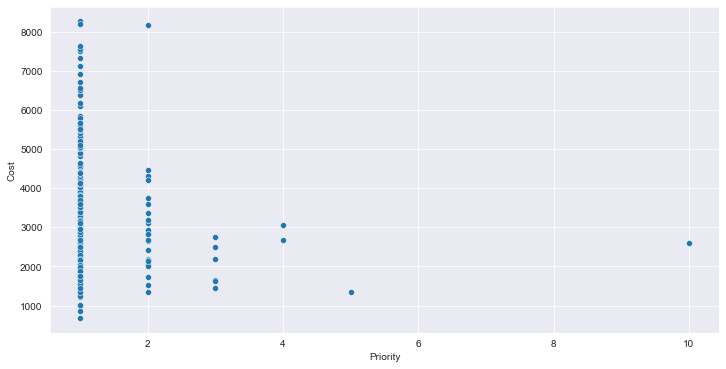

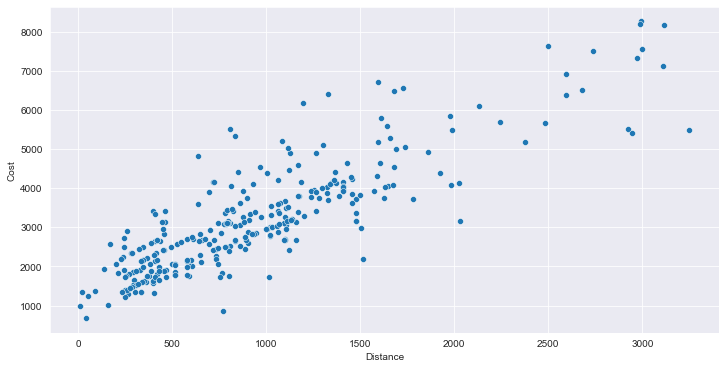

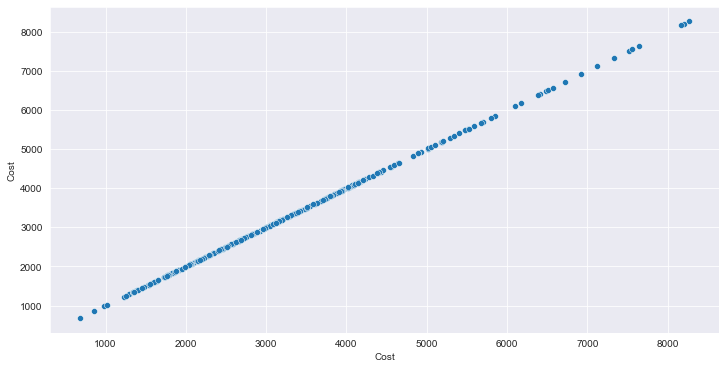

In [478]:
#LINEARITY CHECK>>>#to check price has linear relation or not with Indep. var's

for i, col in enumerate (df_numeric.columns):
    plt.figure(i)
    sns.scatterplot(x=df_numeric[col],y=df_numeric['Cost'])

## Target Variable- Cost

In [479]:
df.describe()

,Priority,Distance,Cost
count,306.000000,306.000000,306.000000
mean,1.196078,960.526144,3226.464771
std,0.715714,639.685113,1429.989144
min,1.000000,9.000000,683.620000
25%,1.000000,452.250000,2169.320000
50%,1.000000,835.000000,3004.175000
75%,1.000000,1264.750000,3938.597500
max,10.000000,3247.000000,8265.170000


C:\Users\v_v\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


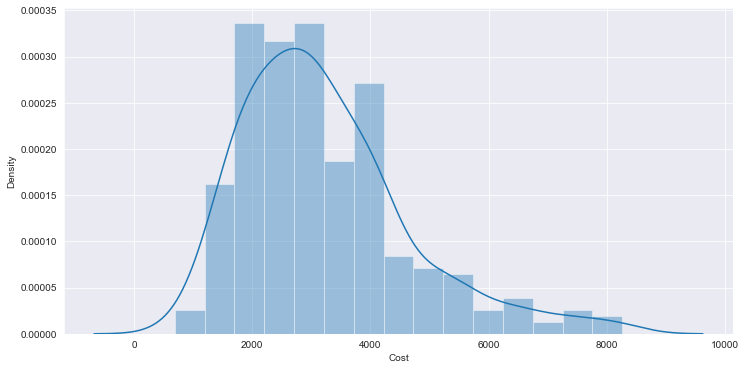

In [480]:
sns.distplot(df['Cost'])
plt.show()

C:\Users\v_v\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Density or Relative Frequency Of Ships By Price')

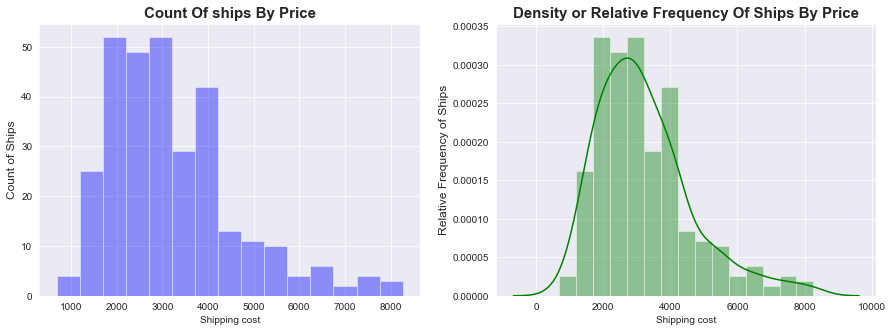

In [481]:
# target variable: Cost of ship

fig, ax= plt.subplots(1,2,figsize=(15,5))

sns.distplot(df['Cost'], norm_hist=False, kde=False, ax=ax[0], color='blue')
ax[0].set_xlabel('Shipping cost')
ax[0].set_ylabel('Count of Ships',size=12)
ax[0].set_title('Count Of ships By Price',size=15,weight="bold")

sns.distplot(df['Cost'], kde=True, ax=ax[1], color='green')
ax[1].set_xlabel('Shipping cost')
ax[1].set_ylabel('Relative Frequency of Ships',size=12)
ax[1].set_title('Density or Relative Frequency Of Ships By Price',size=15,weight="bold")

# Observations on Target Variable- Cost:
    
1. The target variable price has a positive skew, however majority of the cars are low priced.


2. More than 50% of the Ships (around 150 out of total of 306) are priced 2,200  to 4,000 and 
   close to 25% cars are priced between 3000 and 4,000. 
   So around 80% of ships are priced between 1,500 to 6000. 


<b> 

- Distance variable appears to have a linear relation with Cost
    
- Priority don't have a relation with price or relationship isn't strong. None of the varibales appear to have polynomial relation with price.

- In linear regression assumptions validation section we will check for linearity assumption in detail 

## Correlation Matrix

In [482]:
df.corr()

,Priority,Distance,Cost
Priority,1.000000,-0.085389,-0.120806
Distance,-0.085389,1.000000,0.860830
Cost,-0.120806,0.860830,1.000000


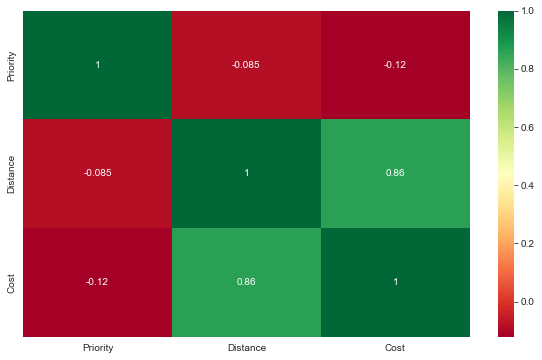

In [483]:

import seaborn as sns
#get correlations of each features in dataset
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,6))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# Useful insights from Corr Heatmap


 1. <b> Dependent var and indep. var's<b>

> Positive corr: 'Cost' highly correlated with 'Distance'
    
2. <b> Correlation among independent variables:<b>

> 'Cost' has very low correlation with 'Priority'

We'll cross check and pay attention to multicollinearity in assumptions validation section using VIF score.

In [484]:
df.head()

,Origin City,Origin State,Destination City,Destination State,Route Class,Priority,Distance,Cost
0,ANNISTON,AL,BAYPORT,TX,Red,1,808,3105.12
1,ANNISTON,AL,HOUSTON,TX,Green,1,779,3357.28
2,MAGNESS,AR,KINGSPORT,TN,Green,2,657,2670.23
3,MAGNESS,AR,BAYPORT,TX,Red,1,610,2715.14
4,VERNON,CA,HARPERTOWN,CA,Red,1,235,2241.49


##  Categorical Data

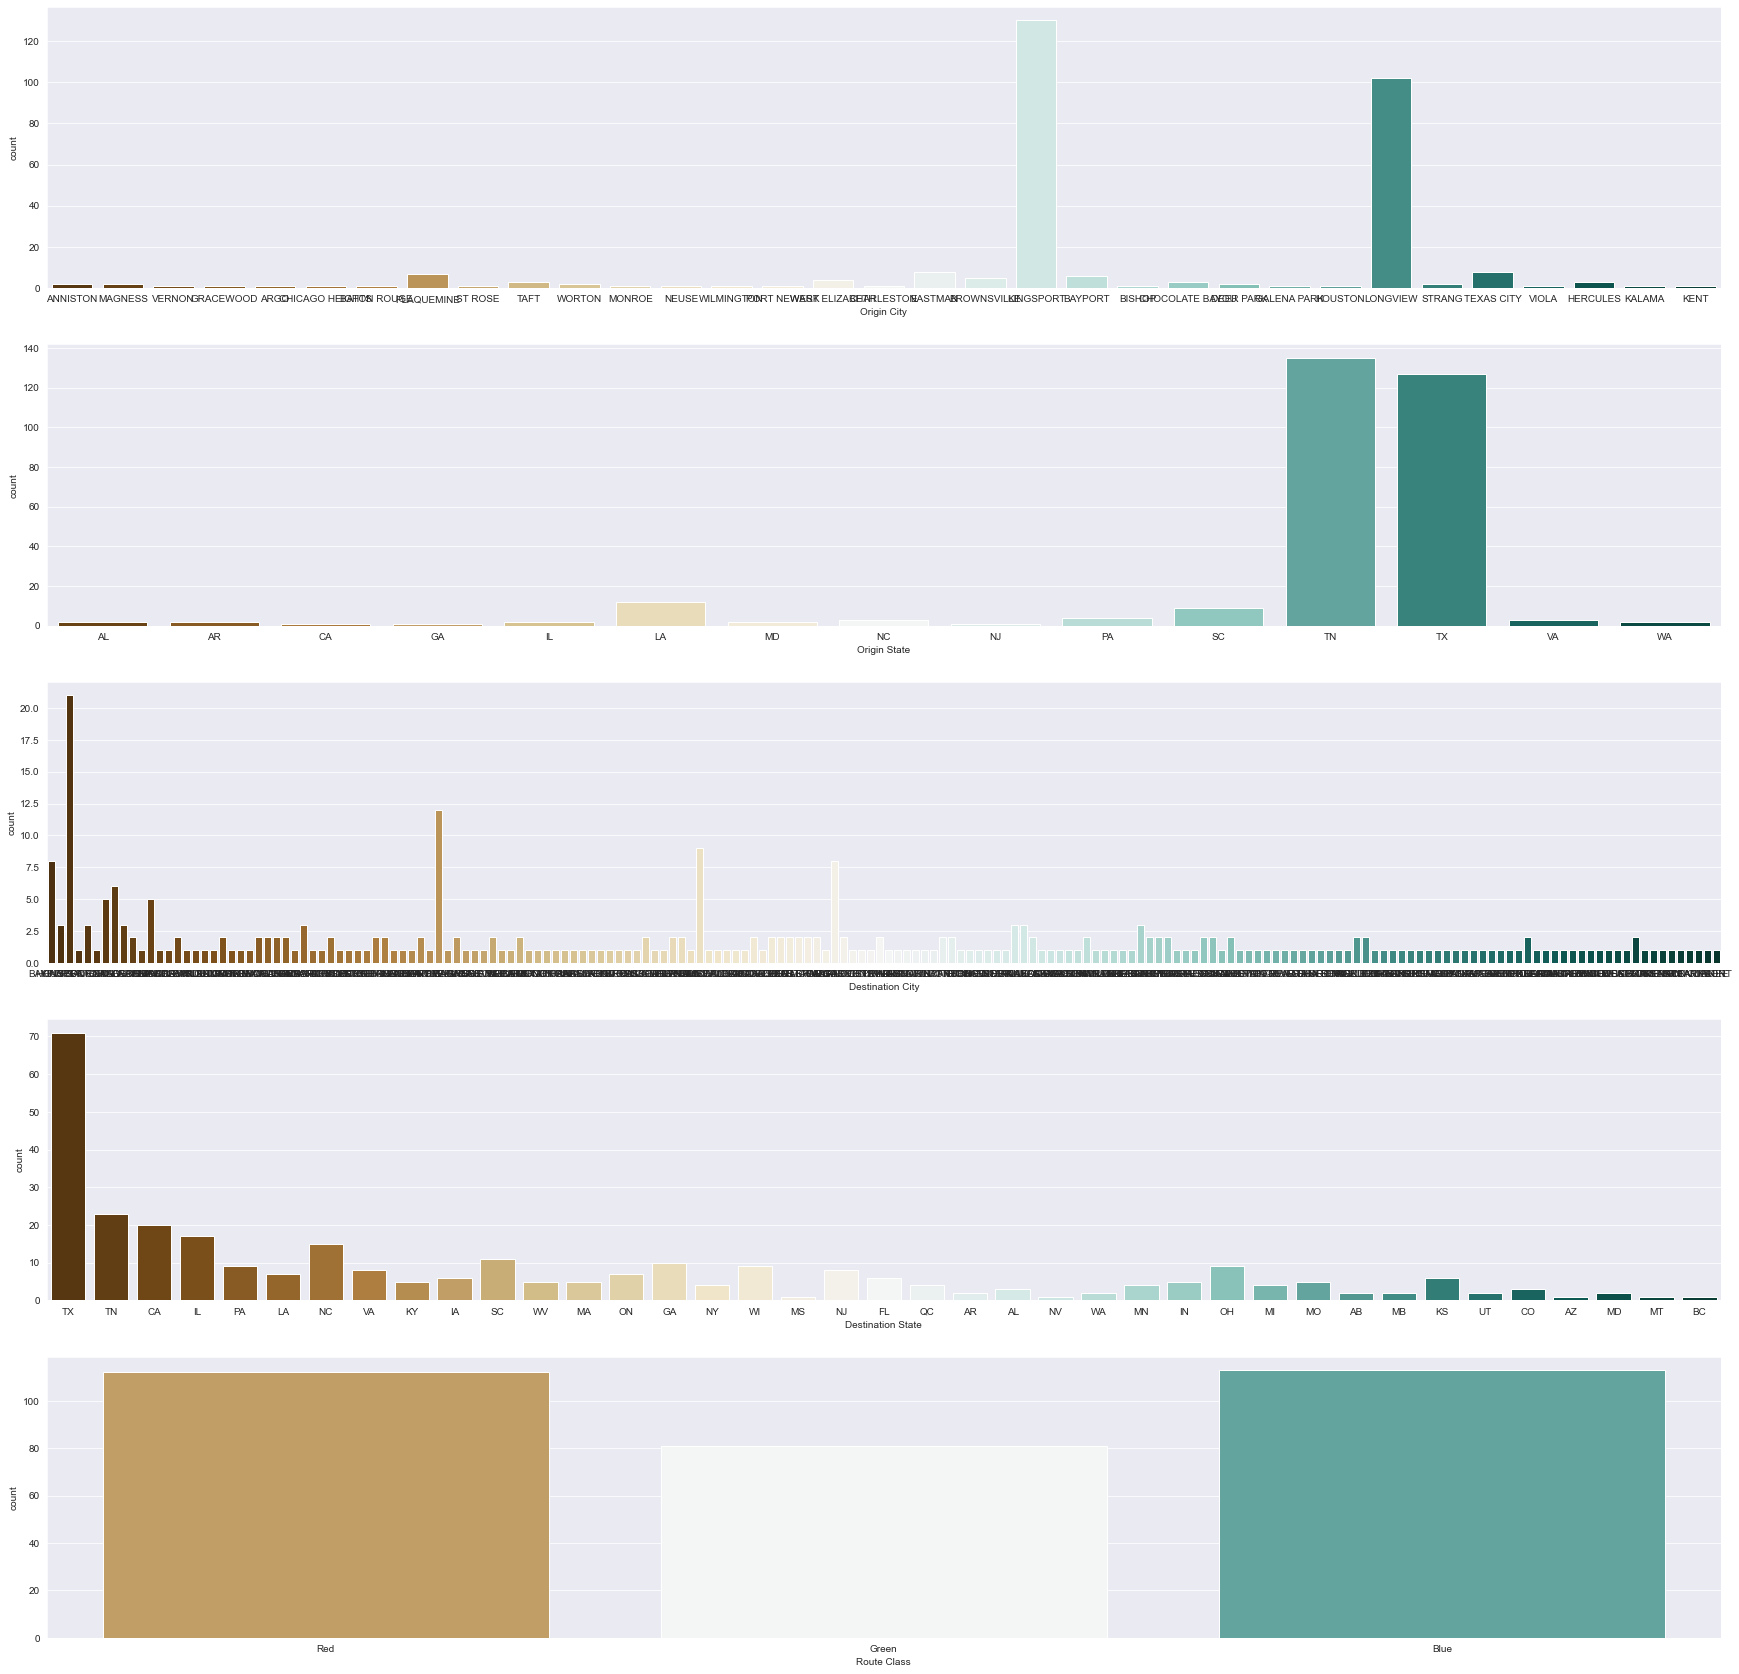

In [485]:
#Exploring ditribution of  categorical variables in the datset

fig, ax = plt.subplots(figsize=(30,30), ncols=1, nrows=5)
sns.countplot(x="Origin City", data=df, ax=ax[0],palette="BrBG")
sns.countplot(x="Origin State", data=df, ax=ax[1],palette="BrBG")
sns.countplot(x="Destination City", data=df, ax=ax[2],palette="BrBG")
sns.countplot(x="Destination State", data=df, ax=ax[3],palette="BrBG")
sns.countplot(x="Route Class", data=df, ax=ax[4],palette="BrBG")

plt.show()

In [486]:
for feature in df.columns[:]:
    if df[feature].dtype=='object':
        print(feature,":",len(df[feature].unique()),'labels')
        #

Origin City : 33 labels
Origin State : 15 labels
Destination City : 186 labels
Destination State : 39 labels
Route Class : 3 labels


## Destination City labels are so many compared to other levels of categorical variables

In [487]:
#Checking for number of unique values in categorical columns 
for i in df.columns:
    if df[i].dtype =='object':
        print(f"{i}: column has {len(df[i].unique())} unique values with {df[i].unique()} \n")

Origin City: column has 33 unique values with ['ANNISTON' 'MAGNESS' 'VERNON' 'GRACEWOOD' 'ARGO' 'CHICAGO HEIGHTS'
 'BATON ROUGE' 'PLAQUEMINE' 'ST ROSE' 'TAFT' 'WORTON' 'MONROE' 'NEUSE'
 'WILMINGTON' 'PORT NEWARK' 'WEST ELIZABETH' 'CHARLESTON' 'EASTMAN'
 'BROWNSVILLE' 'KINGSPORT' 'BAYPORT' 'BISHOP' 'CHOCOLATE BAYOU'
 'DEER PARK' 'GALENA PARK' 'HOUSTON' 'LONGVIEW' 'STRANG' 'TEXAS CITY'
 'VIOLA' 'HERCULES' 'KALAMA' 'KENT'] 

Origin State: column has 15 unique values with ['AL' 'AR' 'CA' 'GA' 'IL' 'LA' 'MD' 'NC' 'NJ' 'PA' 'SC' 'TN' 'TX' 'VA'
 'WA'] 

Destination City: column has 186 unique values with ['BAYPORT' 'HOUSTON' 'KINGSPORT' 'HARPERTOWN' 'SAUGET' 'WEST ELIZABETH'
 'ARGO' 'LONGVIEW' 'TALLA BENA' 'CROSBY' 'GARLAND' 'VERNON' 'HICKORY'
 'HUDSON' 'NEVILLE ISLAND' 'DANVILLE' 'BROWN SUMMIT' 'BARDSTOWN'
 'SIOUX CITY' 'RURAL RETREAT' 'GASTON' 'FLORENCE' 'MILLWOOD'
 'INDIAN ORCHARD' 'HAMILTON' 'CALHOUN' 'EASTMAN' 'ASHEBORO' 'TEXAS CITY'
 'NIAGARA FALLS' 'NEUSE' 'CHARITY CHURCH' 'MIDDLETON' 

In [488]:
#Checking for number of unique value counts in categorical columns 
for i in df.columns:
    if df[i].dtype =='object':
        print(f"{i}: column has {len(df[i].unique())} unique values, Below are top 5 value counts : \n {pd.DataFrame(df[i].value_counts().nlargest(n=5))} \n")

Origin City: column has 33 unique values, Below are top 5 value counts : 
             Origin City
KINGSPORT           130
LONGVIEW            102
TEXAS CITY            8
EASTMAN               8
PLAQUEMINE            7 

Origin State: column has 15 unique values, Below are top 5 value counts : 
     Origin State
TN           135
TX           127
LA            12
SC             9
PA             4 

Destination City: column has 186 unique values, Below are top 5 value counts : 
              Destination City
KINGSPORT                  21
EAGLE PASS                 12
BROWNSVILLE                 9
BAYPORT                     8
LAREDO                      8 

Destination State: column has 39 unique values, Below are top 5 value counts : 
     Destination State
TX                 71
TN                 23
CA                 20
IL                 17
NC                 15 

Route Class: column has 3 unique values, Below are top 5 value counts : 
        Route Class
Blue           113
Red      

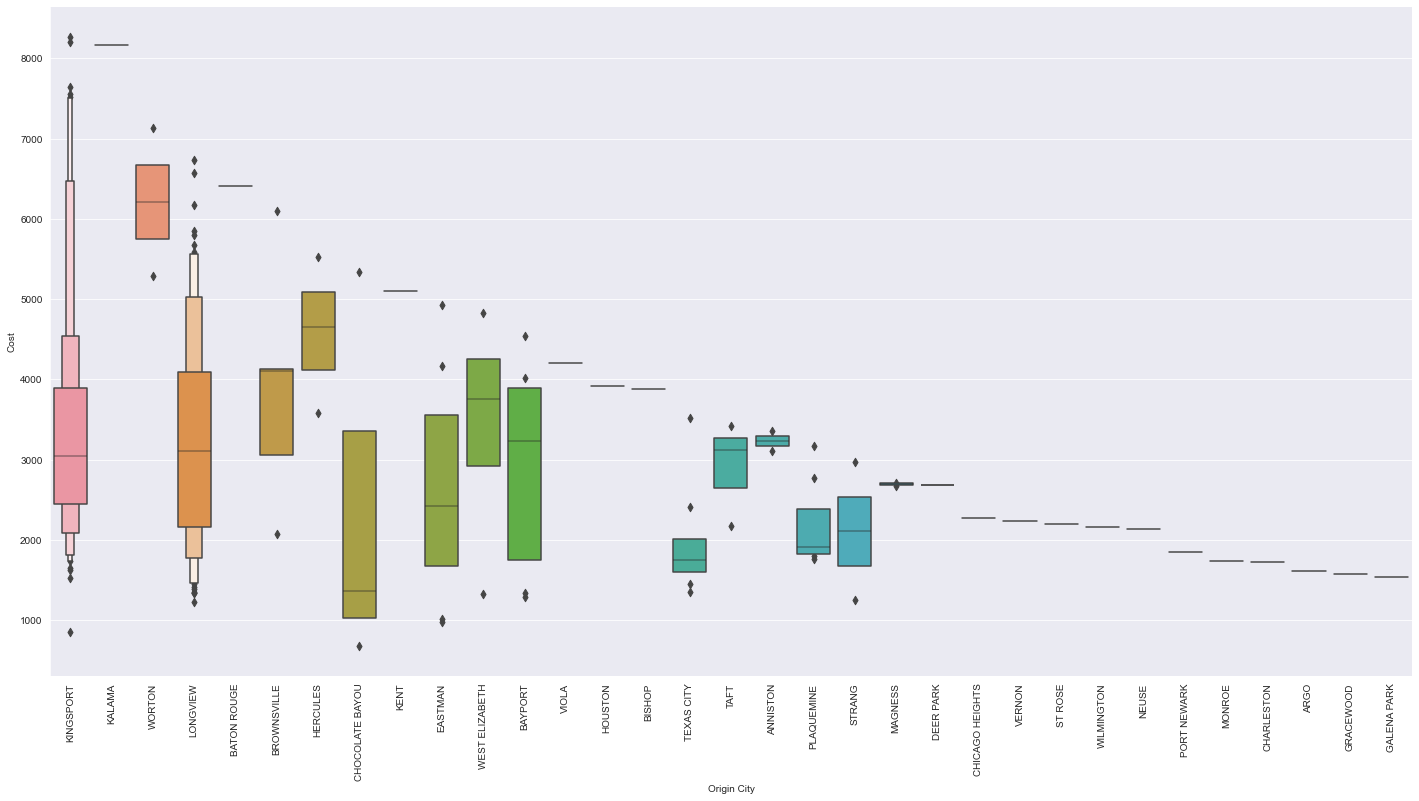

In [489]:
# Origin City vs Cost
sns.catplot(y = "Cost", x = "Origin City", data = df.sort_values("Cost", ascending = False), kind="boxen", height = 10, aspect = 2)
plt.xticks(rotation = 90)
# saving the figure.
plt.savefig("OriginCityvsCost.png",
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = True,
            facecolor ="y",
            edgecolor ='w',
            orientation ='landscape')
plt.show()

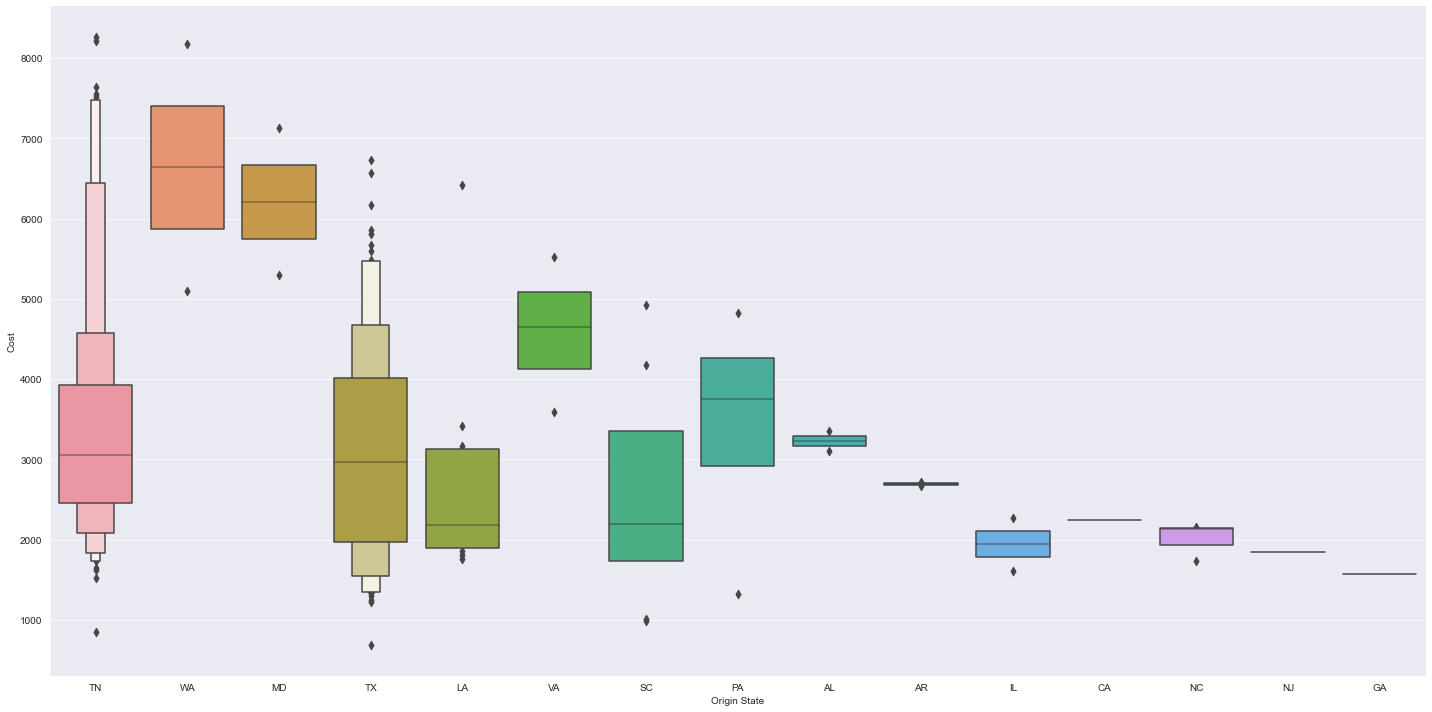

In [490]:
# Origin State vs Cost
sns.catplot(y = "Cost", x = "Origin State", data = df.sort_values("Cost", ascending = False), kind="boxen", height = 10, aspect = 2)
plt.show()

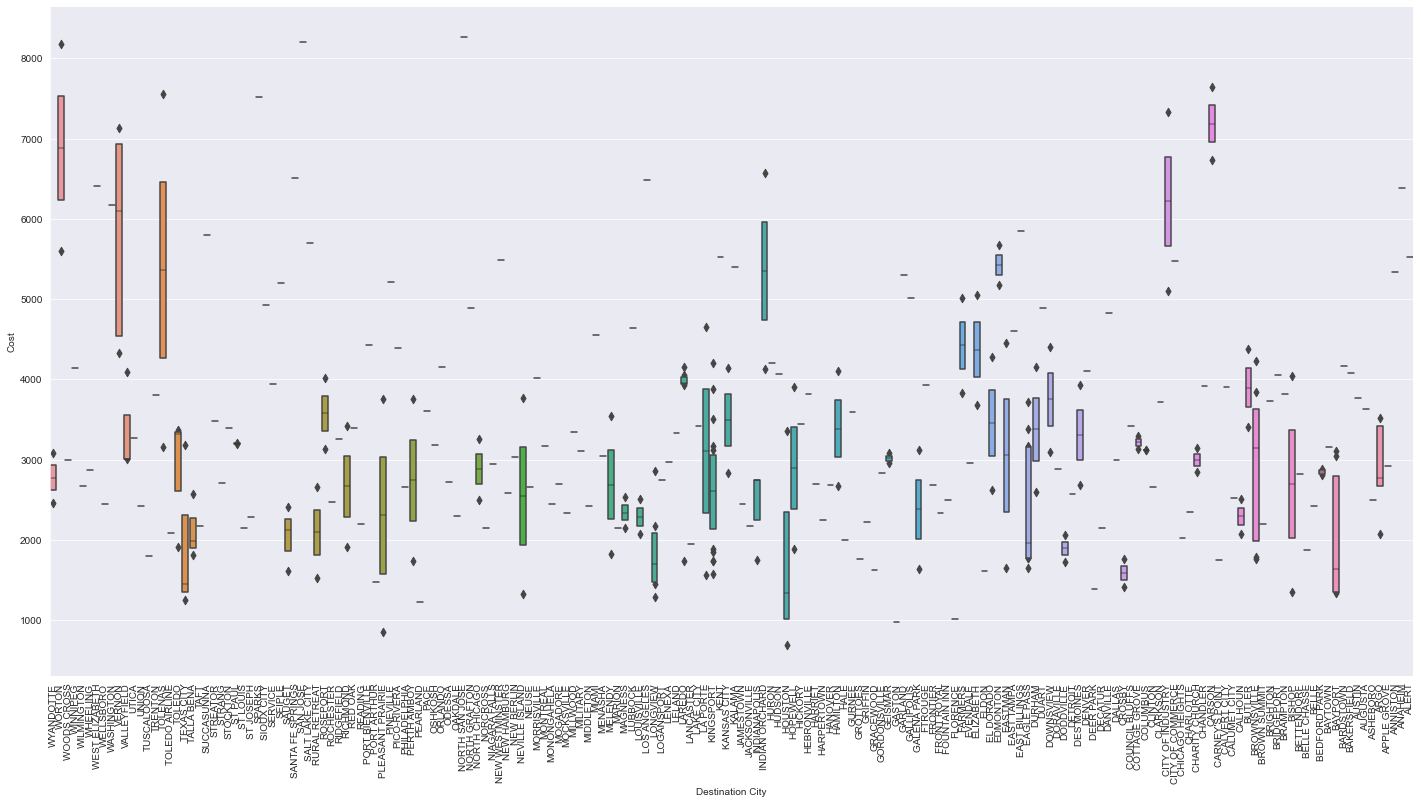

In [491]:
# Destination City vs Cost
sns.catplot(y = "Cost", x = "Destination City", data = df.sort_values("Destination City", ascending = False), kind="boxen", height = 10, aspect = 2)
plt.xticks(rotation = 90)
plt.show()

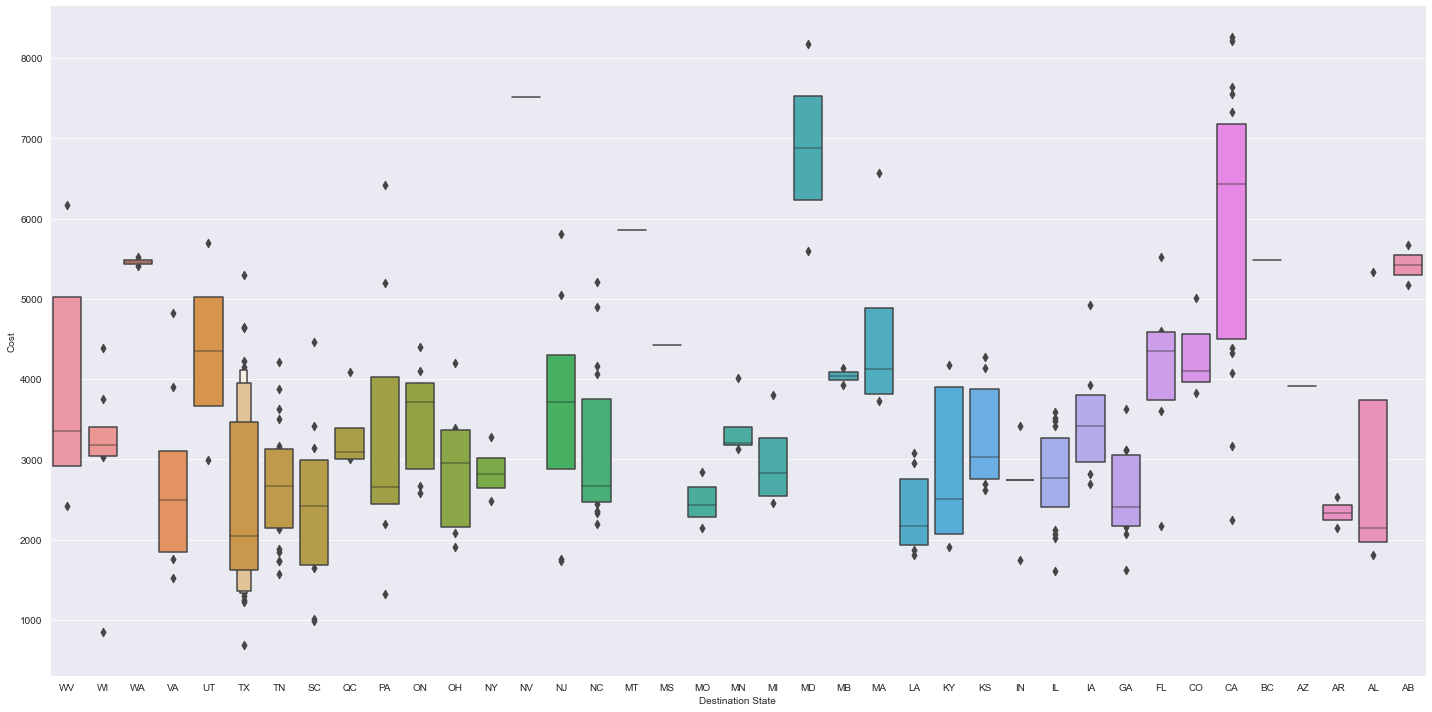

In [492]:
# Destination State vs Cost
sns.catplot(y = "Cost", x = "Destination State", data = df.sort_values("Destination State", ascending = False), kind="boxen", height = 10, aspect = 2)
plt.show()

In [493]:
df['Route Class'].value_counts()

Blue     113
Red      112
Green     81
Name: Route Class, dtype: int64

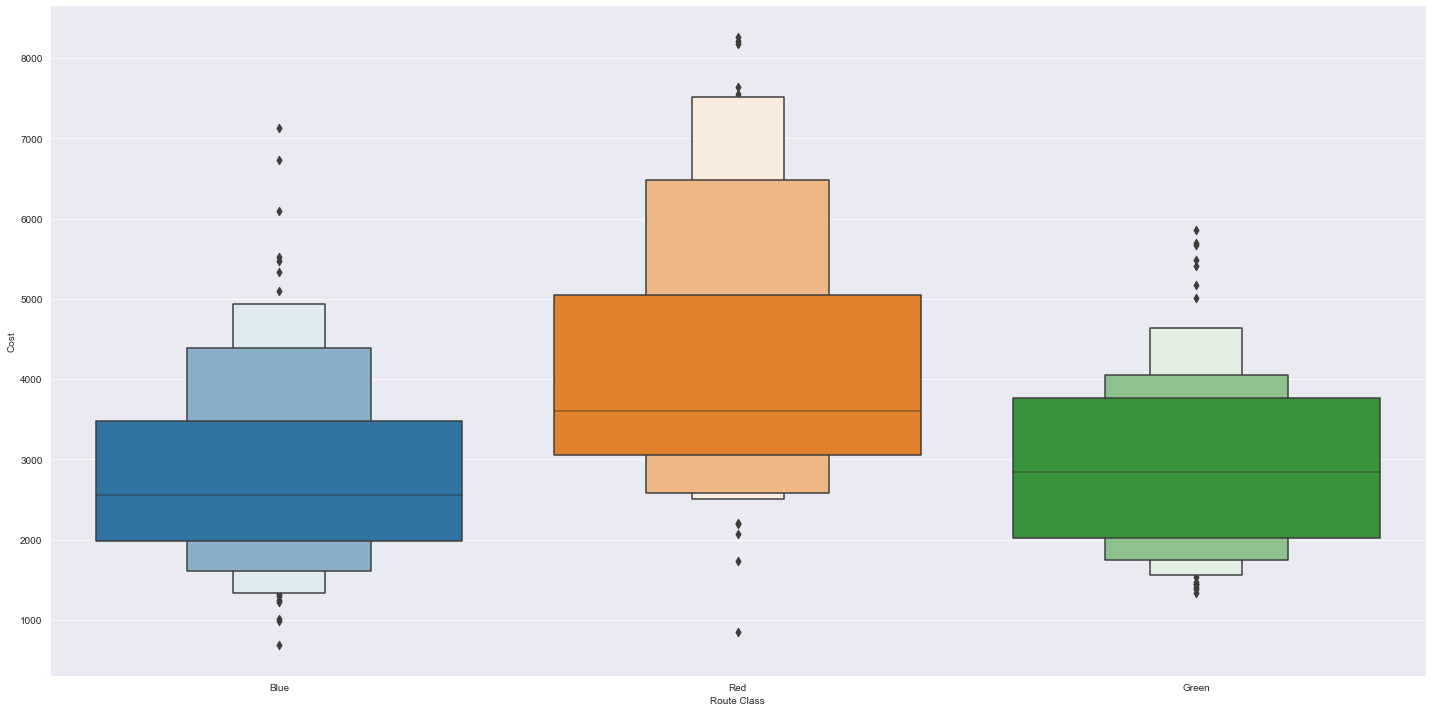

In [494]:
# Route Class vs Cost
sns.catplot(y = "Cost", x = "Route Class", data = df.sort_values("Route Class", ascending = False), kind="boxen", height = 10, aspect = 2)
plt.xticks([0,1,2],["Blue", "Red","Green"])
# saving the figure.
plt.savefig("RouteClassvsCost.png",
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = True,
            facecolor ="y",
            edgecolor ='w',
            orientation ='landscape')
plt.show()

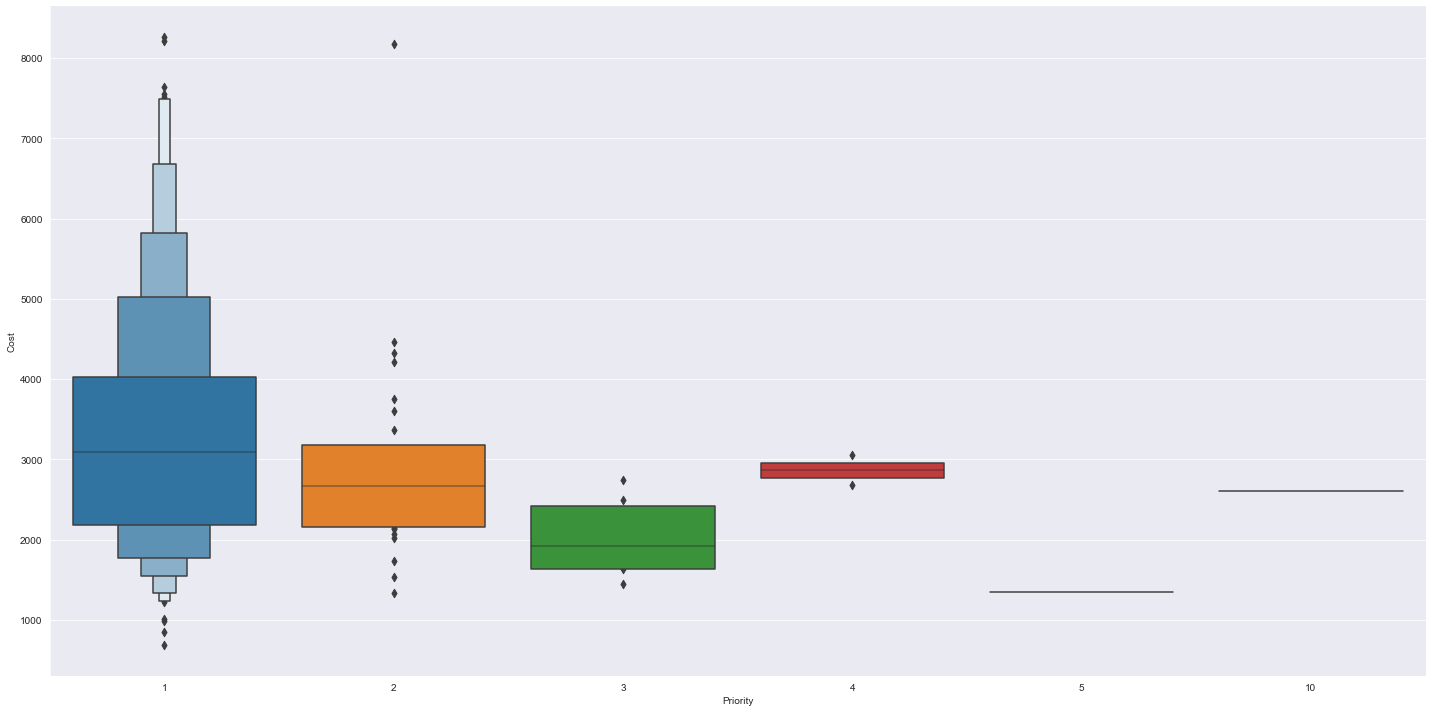

In [495]:
# Priority vs Cost
sns.catplot(y = "Cost", x = "Priority", data = df.sort_values("Priority", ascending = False), kind="boxen", height = 10, aspect = 2)
plt.show()

## Aggregations

In [496]:
Priority_origin=df.groupby(['Origin State','Origin City','Priority']).size().reset_index().rename(columns={0:'Priority Count'})
Priority_origin

,Origin State,Origin City,Priority,Priority Count
0,AL,ANNISTON,1,2
1,AR,MAGNESS,1,1
2,AR,MAGNESS,2,1
3,CA,VERNON,1,1
4,GA,GRACEWOOD,1,1
5,IL,ARGO,1,1
6,IL,CHICAGO HEIGHTS,1,1
7,LA,BATON ROUGE,1,1
8,LA,PLAQUEMINE,1,6
9,LA,PLAQUEMINE,2,1


In [497]:
#df.sort_values("Route Class", ascending = False)
df["Route Class"].value_counts()

Blue     113
Red      112
Green     81
Name: Route Class, dtype: int64

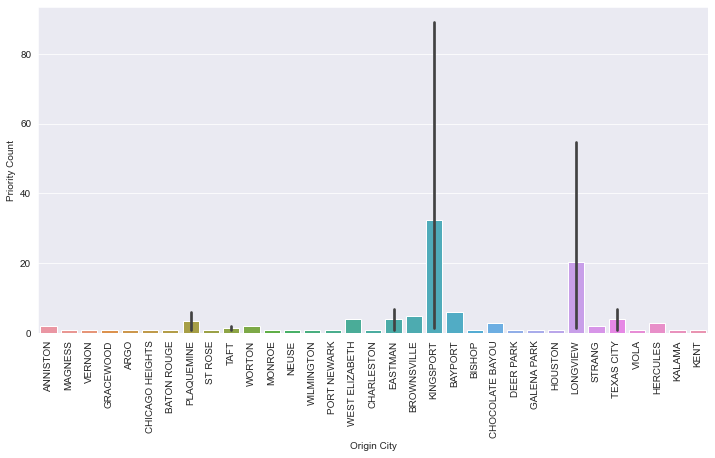

In [498]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 6)
sns.barplot(x='Origin City',y='Priority Count',data=Priority_origin)
plt.xticks(rotation = 90)
plt.show()

## Observations on Origin vs Priority
-Ships originating from Kingsport and Longview has the highest priority

In [499]:
Priority_destination=df.groupby(['Destination State','Destination City','Priority']).size().reset_index().rename(columns={0:'Priority Count'})
Priority_destination

,Destination State,Destination City,Priority,Priority Count
0,AB,EDMONTON,1,2
1,AL,ANNISTON,1,1
2,AL,DECATUR,1,1
3,AL,TUSCALOOSA,1,1
4,AR,MAGNESS,1,1
...,...,...,...,...
204,WV,APPLE GROVE,1,1
205,WV,BELLE,1,1
206,WV,GALLIPOLIS,1,1
207,WV,MILLWOOD,1,1


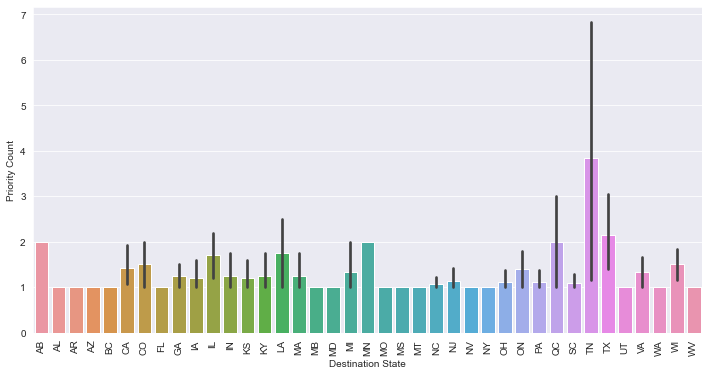

In [500]:

import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 6)
sns.barplot(x='Destination State',y='Priority Count',data=Priority_destination)
plt.xticks(rotation = 90)
plt.show()

## Observations on Destination vs Priority
-Not much observations

## RouteClass vs origin

In [501]:
RouteClass_origin=df.groupby(['Origin State','Origin City','Route Class']).size().reset_index().rename(columns={0:'RouteClassCount'})
RouteClass_origin

,Origin State,Origin City,Route Class,RouteClassCount
0,AL,ANNISTON,Green,1
1,AL,ANNISTON,Red,1
2,AR,MAGNESS,Green,1
3,AR,MAGNESS,Red,1
4,CA,VERNON,Red,1
5,GA,GRACEWOOD,Red,1
6,IL,ARGO,Red,1
7,IL,CHICAGO HEIGHTS,Blue,1
8,LA,BATON ROUGE,Green,1
9,LA,PLAQUEMINE,Green,1


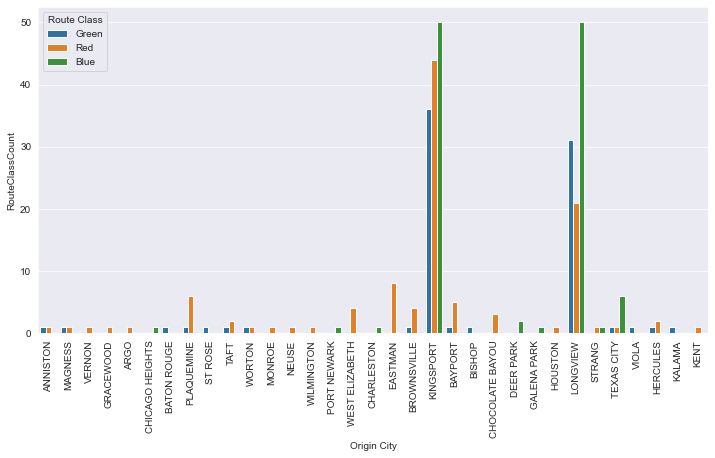

In [502]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 6)
sns.barplot(x='Origin City',y='RouteClassCount',hue='Route Class',data=RouteClass_origin)
plt.xticks(rotation = 90)
# saving the figure.
plt.savefig("OriginCityvsRouteClassvsCount.png",
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = True,
            facecolor ="y",
            edgecolor ='w',
            orientation ='landscape')
plt.show()

## RouteClass vs origin

In [503]:
RouteClass_Destination=df.groupby(['Destination State','Destination City','Route Class']).size().reset_index().rename(columns={0:'RouteClassCount'})
RouteClass_Destination

,Destination State,Destination City,Route Class,RouteClassCount
0,AB,EDMONTON,Blue,2
1,AL,ANNISTON,Red,1
2,AL,DECATUR,Red,1
3,AL,TUSCALOOSA,Blue,1
4,AR,MAGNESS,Green,1
...,...,...,...,...
217,WV,APPLE GROVE,Red,1
218,WV,BELLE,Red,1
219,WV,GALLIPOLIS,Green,1
220,WV,MILLWOOD,Red,1


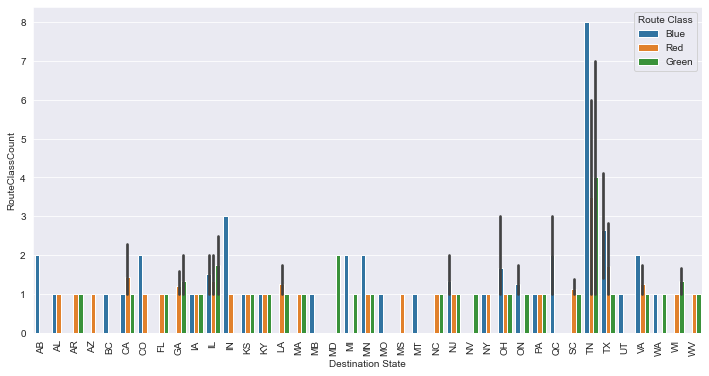

In [504]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 6)
sns.barplot(x='Destination State',y='RouteClassCount',hue='Route Class',data=RouteClass_Destination)
plt.xticks(rotation = 90)
plt.show()

## Priority vs Cost

In [505]:
df['Priority'].value_counts()

1     267
2      29
3       6
4       2
10      1
5       1
Name: Priority, dtype: int64

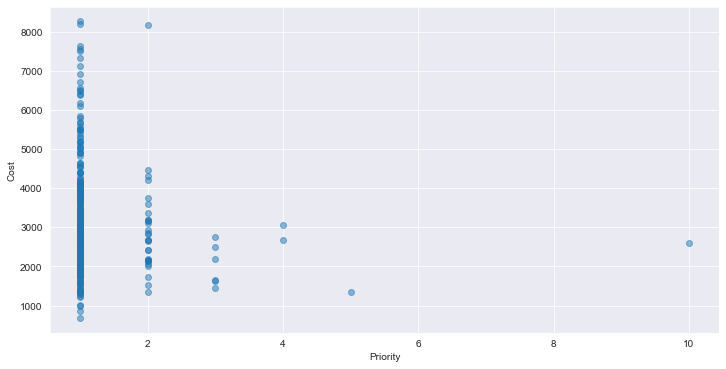

In [506]:
plt.scatter(df['Priority'],df['Cost'], alpha = 0.5)
plt.xlabel("Priority")
plt.ylabel("Cost")
plt.show()

## Observations on Priority vs Cost
-Most of the ships (267/306=87%) have highest priority 1

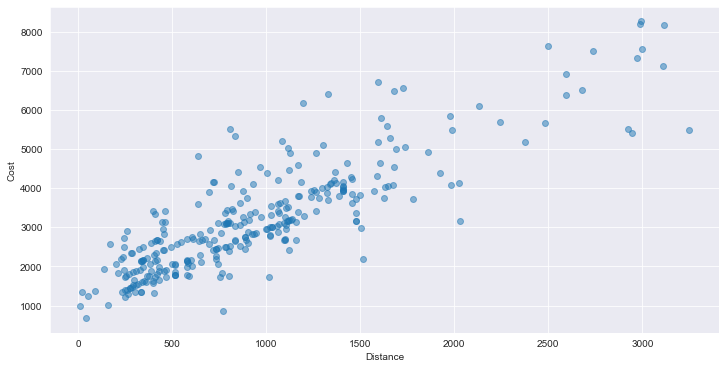

In [507]:
plt.scatter(df['Distance'],df['Cost'], alpha = 0.5)
plt.xlabel("Distance")
plt.ylabel("Cost")
plt.show()

## Observations on Distance vs Cost
#-There is a good linear relationship (Corr:0.86)-  As Distance increases,Shipping cost increases

## Group by on cities to top 5 and rest in to 1 city


In [508]:
# df['Destination City'].value_counts()

## Feature Engineering

In [509]:
df

,Origin City,Origin State,Destination City,Destination State,Route Class,Priority,Distance,Cost
0,ANNISTON,AL,BAYPORT,TX,Red,1,808,3105.12
1,ANNISTON,AL,HOUSTON,TX,Green,1,779,3357.28
2,MAGNESS,AR,KINGSPORT,TN,Green,2,657,2670.23
3,MAGNESS,AR,BAYPORT,TX,Red,1,610,2715.14
4,VERNON,CA,HARPERTOWN,CA,Red,1,235,2241.49
...,...,...,...,...,...,...,...,...
301,HERCULES,VA,GURNEE,IL,Red,1,1060,3587.94
302,HERCULES,VA,ALERT,FL,Red,1,806,5525.39
303,HERCULES,VA,LA PORTE,TX,Green,1,1431,4653.60
304,KALAMA,WA,WORTON,MD,Green,2,3117,8172.43


In [510]:
df['cost_distance_ratio']=df['Cost']/df['Distance']

In [511]:
df

,Origin City,Origin State,Destination City,Destination State,Route Class,Priority,Distance,Cost,cost_distance_ratio
0,ANNISTON,AL,BAYPORT,TX,Red,1,808,3105.12,3.842970
1,ANNISTON,AL,HOUSTON,TX,Green,1,779,3357.28,4.309730
2,MAGNESS,AR,KINGSPORT,TN,Green,2,657,2670.23,4.064277
3,MAGNESS,AR,BAYPORT,TX,Red,1,610,2715.14,4.451049
4,VERNON,CA,HARPERTOWN,CA,Red,1,235,2241.49,9.538255
...,...,...,...,...,...,...,...,...,...
301,HERCULES,VA,GURNEE,IL,Red,1,1060,3587.94,3.384849
302,HERCULES,VA,ALERT,FL,Red,1,806,5525.39,6.855323
303,HERCULES,VA,LA PORTE,TX,Green,1,1431,4653.60,3.251992
304,KALAMA,WA,WORTON,MD,Green,2,3117,8172.43,2.621890


In [512]:
df.sort_values(by=['cost_distance_ratio']).tail(25)

,Origin City,Origin State,Destination City,Destination State,Route Class,Priority,Distance,Cost,cost_distance_ratio
22,MONROE,NC,KINGSPORT,TN,Red,1,247,1737.27,7.033482
230,LONGVIEW,TX,BROWNSVILLE,TN,Green,1,443,3143.91,7.096862
46,KINGSPORT,TN,ASHEBORO,NC,Red,3,343,2497.14,7.280292
94,KINGSPORT,TN,RICHMOND,IN,Red,1,463,3418.12,7.382549
29,WEST ELIZABETH,PA,DANVILLE,VA,Red,1,635,4828.37,7.603732
148,KINGSPORT,TN,JAMESTOWN,NC,Red,1,320,2440.50,7.626563
74,KINGSPORT,TN,RICHMOND,KY,Red,1,244,1912.77,7.839221
103,KINGSPORT,TN,LELAND,NC,Red,1,409,3330.80,8.143765
126,KINGSPORT,TN,CHARLOTTE,NC,Red,1,285,2351.72,8.251649
104,KINGSPORT,TN,MOCKSVILLE,NC,Red,1,280,2338.76,8.352714


# will do transormations on data

## Outliers

##### Which Machine LEarning Models Are Sensitive To Outliers?
1. Naivye Bayes Classifier--- Not Sensitive To Outliers
2. SVM--------                Not Sensitive To Outliers          
3. Linear Regression----------  Sensitive To Outliers
4. Logistic Regression-------   Sensitive To Outliers
5. Decision Tree Regressor or Classifier---- Not Sensitive
6. Ensemble(RF,XGboost,GB)------- Not Sensitive
7. KNN--------------------------- Not Sensitive 
8. Kmeans------------------------ Sensitive
9. Hierarichal------------------- Sensitive 
10. PCA-------------------------- Sensitive 
11. Neural Networks-------------- Sensitive

### What are the criteria to identify an outlier?

1. Data point that falls outside of 1.5 times of an interquartile range above the 3rd quartile and below the 1st quartile
2. Data point that falls outside of 3 standard deviations. we can use a z score and if the z score falls outside of 2 standard deviation

### What is the reason for an outlier to exists in a dataset?

1. Variability in the data
2. An experimental measurement error

### What are the impacts of having outliers in a dataset?

1. It causes various problems during our statistical analysis
2. It may cause a significant impact on the mean and the standard deviation

### Various ways of finding the outlier.
1. Using scatter plots
2. Box plot
3. using z score
4. using the IQR interquantile range



## InterQuantile Range

75%- 25% values in a dataset

### Steps
#### 1. Arrange the data in increasing order
#### 2. Calculate first(q1) and third quartile(q3)
#### 3. Find interquartile range (q3-q1)
#### 4.Find lower bound q1*1.5
#### 5.Find upper bound q3*1.5

Anything that lies outside of lower and upper bound is an outlier

C:\Users\v_v\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Distance', ylabel='Density'>

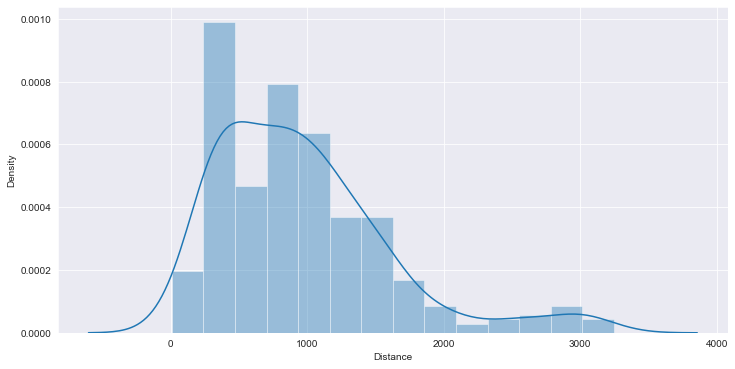

In [513]:
sns.distplot(df['Distance'])

In [514]:
#### If you want to check whether feature is guassian or normal distributed
#### Q-Q plot
import scipy.stats as stat
import pylab 
def plot_data(df,feature):
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    df[feature].hist()
    plt.subplot(1,2,2)
    stat.probplot(df[feature],dist='norm',plot=pylab)
    plt.show()

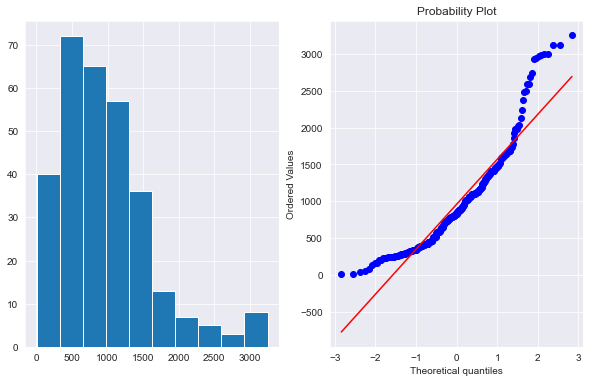

In [515]:
plot_data(df,'Distance')

### Logarithmic Transformation

In [516]:
# import numpy as np
# df['Distance_log']=np.log(df['Distance'])
# plot_data(df,'Distance_log')

##### Square Root Transformation

In [517]:
# df['Distance_sqaure']=df.Distance**(1/2)
# plot_data(df,'Distance_sqaure')

In [518]:
# #### Exponential Transdormation
# df['Distance_exponential']=df.Distance**(1/1.2)
# plot_data(df,'Distance_exponential')

## BoxCOx Transformation
The Box-Cox transformation is defined as:

T(Y)=(Y exp(λ)−1)/λ

where Y is the response variable and λ is the transformation parameter. λ varies from -5 to 5. In the transformation, all values of λ are considered and the optimal value for a given variable is selected.

In [519]:
# df['Distance_Boxcox'],parameters=stat.boxcox(df['Distance'])

In [520]:
# print(parameters)
# plot_data(df,'Distance_Boxcox')

## Outlier Distance column- Gaussian Distributed

Text(0, 0.5, 'No of Ships')

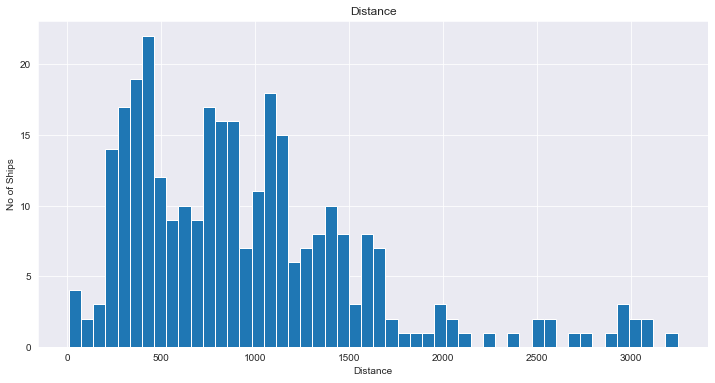

In [521]:
figure=df.Distance.hist(bins=50)
figure.set_title('Distance')
figure.set_xlabel('Distance')
figure.set_ylabel('No of Ships')

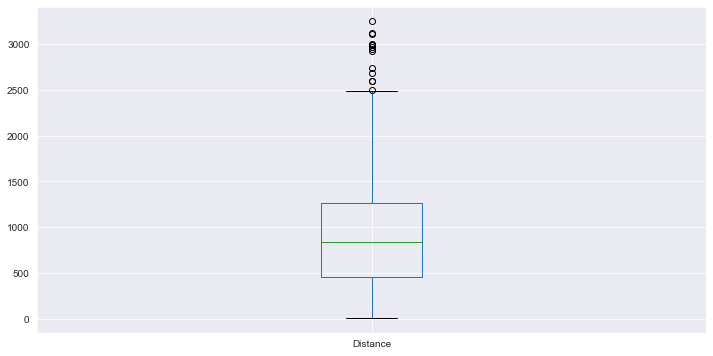

In [522]:
figure=df.boxplot(column="Distance")

In [523]:
df['Distance'].describe()

count     306.000000
mean      960.526144
std       639.685113
min         9.000000
25%       452.250000
50%       835.000000
75%      1264.750000
max      3247.000000
Name: Distance, dtype: float64

In [524]:
##### Assuming Age follows A Gaussian Distribution we will calculate the boundaries which differentiates the outliers

uppper_boundary=df['Distance'].mean() + 3* df['Distance'].std()
lower_boundary=df['Distance'].mean() - 3* df['Distance'].std()
print(lower_boundary), print(uppper_boundary),print(df['Distance'].mean())

-958.5291946996803
2879.5814822813795
960.5261437908497


(None, None, None)

In [525]:
#### Lets compute the Interquantile range to calculate the boundaries
IQR=df.Distance.quantile(0.75)-df.Distance.quantile(0.25)
lower_bridge=df['Distance'].quantile(0.25)-(IQR*1.5)
upper_bridge=df['Distance'].quantile(0.75)+(IQR*1.5)
print(lower_bridge), print(upper_bridge)

-766.5
2483.5


(None, None)

In [526]:
outlierremoved_data=df.copy()

In [527]:
Distance_outlierremoved_data_df=outlierremoved_data.loc[outlierremoved_data['Distance']>2484]
Distance_outlierremoved_data_df

,Origin City,Origin State,Destination City,Destination State,Route Class,Priority,Distance,Cost,cost_distance_ratio
21,WORTON,MD,VERNON,CA,Red,1,3112,7126.23,2.289920
58,KINGSPORT,TN,CITY OF INDUSTRY,CA,Green,1,2973,7330.43,2.465668
61,KINGSPORT,TN,VERNON,CA,Green,1,2594,6927.58,2.670617
81,KINGSPORT,TN,SPARKS,NV,Green,1,2736,7518.08,2.747836
86,KINGSPORT,TN,KENT,WA,Green,1,2922,5518.36,1.888556
97,KINGSPORT,TN,ANAHEIM,CA,Green,1,2596,6388.32,2.460832
108,KINGSPORT,TN,TOLENAS,CA,Green,1,2997,7557.31,2.521625
117,KINGSPORT,TN,SANTA FE SPRINGS,CA,Green,1,2680,6510.20,2.429179
129,KINGSPORT,TN,CARSON,CA,Green,1,2499,7641.99,3.058019
155,KINGSPORT,TN,NORTH SAN JOSE,CA,Green,1,2990,8265.17,2.764271


In [528]:
print("Distance outliers: ",len(Distance_outlierremoved_data_df))

Distance outliers:  14


In [529]:
outlierremoved_data.drop(outlierremoved_data.loc[outlierremoved_data['Distance']>2484].index, inplace=True)

In [530]:
outlierremoved_data=outlierremoved_data.reset_index(drop=True)

In [531]:
outlierremoved_data

,Origin City,Origin State,Destination City,Destination State,Route Class,Priority,Distance,Cost,cost_distance_ratio
0,ANNISTON,AL,BAYPORT,TX,Red,1,808,3105.12,3.842970
1,ANNISTON,AL,HOUSTON,TX,Green,1,779,3357.28,4.309730
2,MAGNESS,AR,KINGSPORT,TN,Green,2,657,2670.23,4.064277
3,MAGNESS,AR,BAYPORT,TX,Red,1,610,2715.14,4.451049
4,VERNON,CA,HARPERTOWN,CA,Red,1,235,2241.49,9.538255
...,...,...,...,...,...,...,...,...,...
287,VIOLA,TX,KINGSPORT,TN,Green,2,1361,4209.23,3.092748
288,HERCULES,VA,GURNEE,IL,Red,1,1060,3587.94,3.384849
289,HERCULES,VA,ALERT,FL,Red,1,806,5525.39,6.855323
290,HERCULES,VA,LA PORTE,TX,Green,1,1431,4653.60,3.251992


## Outlier 'Cost' column- Gaussian Distributed

Text(0, 0.5, 'No of Ships')

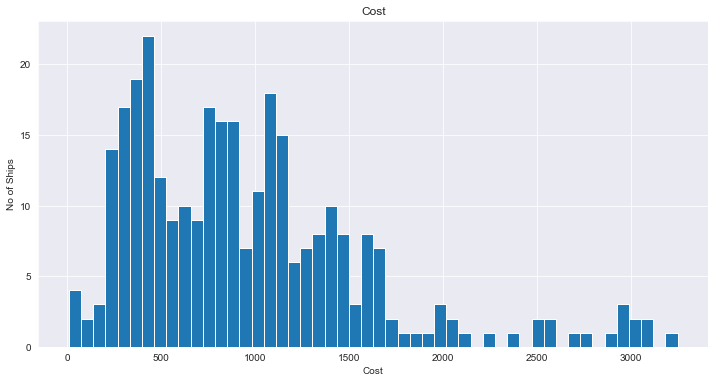

In [532]:
figure=df.Distance.hist(bins=50)
figure.set_title('Cost')
figure.set_xlabel('Cost')
figure.set_ylabel('No of Ships')

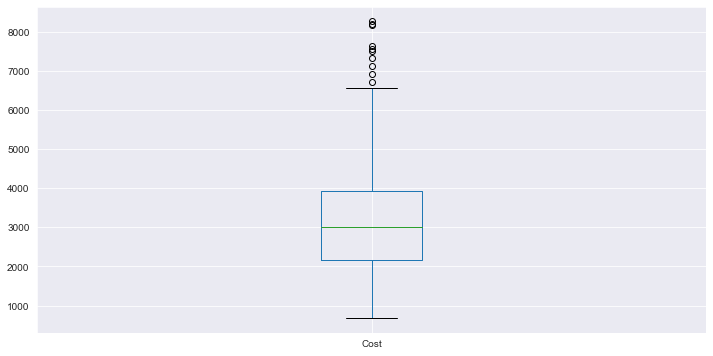

In [533]:
figure=df.boxplot(column="Cost")

In [534]:
df['Cost'].describe()

count     306.000000
mean     3226.464771
std      1429.989144
min       683.620000
25%      2169.320000
50%      3004.175000
75%      3938.597500
max      8265.170000
Name: Cost, dtype: float64

In [535]:
#### Lets compute the Interquantile range to calculate the boundaries
IQR=df.Distance.quantile(0.75)-df.Distance.quantile(0.25)
lower_bridge=df['Cost'].quantile(0.25)-(IQR*1.5)
upper_bridge=df['Cost'].quantile(0.75)+(IQR*1.5)
print(lower_bridge), print(upper_bridge)

950.5700000000002
5157.3475


(None, None)

In [536]:
outlierremoved_data_cost=outlierremoved_data.copy()

In [537]:
outlierremoved_data_cost

,Origin City,Origin State,Destination City,Destination State,Route Class,Priority,Distance,Cost,cost_distance_ratio
0,ANNISTON,AL,BAYPORT,TX,Red,1,808,3105.12,3.842970
1,ANNISTON,AL,HOUSTON,TX,Green,1,779,3357.28,4.309730
2,MAGNESS,AR,KINGSPORT,TN,Green,2,657,2670.23,4.064277
3,MAGNESS,AR,BAYPORT,TX,Red,1,610,2715.14,4.451049
4,VERNON,CA,HARPERTOWN,CA,Red,1,235,2241.49,9.538255
...,...,...,...,...,...,...,...,...,...
287,VIOLA,TX,KINGSPORT,TN,Green,2,1361,4209.23,3.092748
288,HERCULES,VA,GURNEE,IL,Red,1,1060,3587.94,3.384849
289,HERCULES,VA,ALERT,FL,Red,1,806,5525.39,6.855323
290,HERCULES,VA,LA PORTE,TX,Green,1,1431,4653.60,3.251992


In [538]:
cost_distance_outlierremoved_data_df=outlierremoved_data_cost.loc[outlierremoved_data_cost['Cost']>5158]
cost_distance_outlierremoved_data_df=cost_distance_outlierremoved_data_df.append(outlierremoved_data_cost.loc[outlierremoved_data_cost['Cost']<950])
cost_distance_outlierremoved_data_df

,Origin City,Origin State,Destination City,Destination State,Route Class,Priority,Distance,Cost,cost_distance_ratio
8,BATON ROUGE,LA,WEST ELIZABETH,PA,Green,1,1328,6414.26,4.830015
20,WORTON,MD,GARLAND,TX,Green,1,1658,5294.44,3.193269
39,BROWNSVILLE,TN,VERNON,CA,Red,1,2131,6098.90,2.861990
88,KINGSPORT,TN,LOS ANGELES,CA,Green,1,1681,6482.53,3.856353
120,KINGSPORT,TN,EDMONTON,AB,Blue,1,2378,5173.27,2.175471
144,KINGSPORT,TN,SALT LAKE CITY,UT,Blue,1,2243,5701.89,2.542082
170,CHOCOLATE BAYOU,TX,ANNISTON,AL,Red,1,831,5339.84,6.425800
191,LONGVIEW,TX,INDIAN ORCHARD,MA,Green,1,1726,6570.01,3.806495
200,LONGVIEW,TX,WASHINGTON,WV,Green,1,1196,6171.22,5.159883
205,LONGVIEW,TX,SEIPLE,PA,Green,1,1592,5195.46,3.263480


In [539]:
print("Distance and cost outliers: ",len(cost_distance_outlierremoved_data_df))

Distance and cost outliers:  20


In [540]:
cost_distance_outlierremoved_data_df

,Origin City,Origin State,Destination City,Destination State,Route Class,Priority,Distance,Cost,cost_distance_ratio
8,BATON ROUGE,LA,WEST ELIZABETH,PA,Green,1,1328,6414.26,4.830015
20,WORTON,MD,GARLAND,TX,Green,1,1658,5294.44,3.193269
39,BROWNSVILLE,TN,VERNON,CA,Red,1,2131,6098.90,2.861990
88,KINGSPORT,TN,LOS ANGELES,CA,Green,1,1681,6482.53,3.856353
120,KINGSPORT,TN,EDMONTON,AB,Blue,1,2378,5173.27,2.175471
144,KINGSPORT,TN,SALT LAKE CITY,UT,Blue,1,2243,5701.89,2.542082
170,CHOCOLATE BAYOU,TX,ANNISTON,AL,Red,1,831,5339.84,6.425800
191,LONGVIEW,TX,INDIAN ORCHARD,MA,Green,1,1726,6570.01,3.806495
200,LONGVIEW,TX,WASHINGTON,WV,Green,1,1196,6171.22,5.159883
205,LONGVIEW,TX,SEIPLE,PA,Green,1,1592,5195.46,3.263480


In [541]:
outlierremoved_data.drop(outlierremoved_data.loc[outlierremoved_data['Cost']>5158].index, inplace=True)
outlierremoved_data.drop(outlierremoved_data.loc[outlierremoved_data['Cost']<950].index, inplace=True)
outlierremoved_data=outlierremoved_data.reset_index(drop=True)

## Handling Categorical Data
### One can find many ways to handle categorical data. Some of them categorical data are,

### **Nominal data** --> data are not in any order --> **OneHotEncoder** is used in this case
### **Ordinal data** --> data are in order --> **LabelEncoder** is used in this case

In [542]:
outlierremoved_data.head()

,Origin City,Origin State,Destination City,Destination State,Route Class,Priority,Distance,Cost,cost_distance_ratio
0,ANNISTON,AL,BAYPORT,TX,Red,1,808,3105.12,3.842970
1,ANNISTON,AL,HOUSTON,TX,Green,1,779,3357.28,4.309730
2,MAGNESS,AR,KINGSPORT,TN,Green,2,657,2670.23,4.064277
3,MAGNESS,AR,BAYPORT,TX,Red,1,610,2715.14,4.451049
4,VERNON,CA,HARPERTOWN,CA,Red,1,235,2241.49,9.538255


In [543]:
outlierremoved_data.dtypes

Origin City             object
Origin State            object
Destination City        object
Destination State       object
Route Class             object
Priority                 int64
Distance                 int64
Cost                   float64
cost_distance_ratio    float64
dtype: object

In [544]:
outlierremoved_data['Priority']=outlierremoved_data['Priority'].astype(int)

In [545]:
outlierremoved_data

,Origin City,Origin State,Destination City,Destination State,Route Class,Priority,Distance,Cost,cost_distance_ratio
0,ANNISTON,AL,BAYPORT,TX,Red,1,808,3105.12,3.842970
1,ANNISTON,AL,HOUSTON,TX,Green,1,779,3357.28,4.309730
2,MAGNESS,AR,KINGSPORT,TN,Green,2,657,2670.23,4.064277
3,MAGNESS,AR,BAYPORT,TX,Red,1,610,2715.14,4.451049
4,VERNON,CA,HARPERTOWN,CA,Red,1,235,2241.49,9.538255
...,...,...,...,...,...,...,...,...,...
267,TEXAS CITY,TX,BROWNSVILLE,TX,Blue,1,363,1763.31,4.857603
268,VIOLA,TX,KINGSPORT,TN,Green,2,1361,4209.23,3.092748
269,HERCULES,VA,GURNEE,IL,Red,1,1060,3587.94,3.384849
270,HERCULES,VA,LA PORTE,TX,Green,1,1431,4653.60,3.251992


In [546]:
outlierremoved_catdummies_data=pd.get_dummies(outlierremoved_data)

In [547]:
outlierremoved_catdummies_data

,Priority,Distance,Cost,cost_distance_ratio,Origin City_ANNISTON,Origin City_ARGO,Origin City_BAYPORT,Origin City_BISHOP,Origin City_BROWNSVILLE,Origin City_CHARLESTON,...,Destination State_SC,Destination State_TN,Destination State_TX,Destination State_UT,Destination State_VA,Destination State_WI,Destination State_WV,Route Class_Blue,Route Class_Green,Route Class_Red
0,1,808,3105.12,3.842970,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,779,3357.28,4.309730,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,2,657,2670.23,4.064277,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,1,610,2715.14,4.451049,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,1,235,2241.49,9.538255,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,1,363,1763.31,4.857603,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
268,2,1361,4209.23,3.092748,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
269,1,1060,3587.94,3.384849,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
270,1,1431,4653.60,3.251992,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [548]:
outlierremoved_catdummies_data.shape

(272, 247)

In [549]:
outlierremoved_catdummies_data

,Priority,Distance,Cost,cost_distance_ratio,Origin City_ANNISTON,Origin City_ARGO,Origin City_BAYPORT,Origin City_BISHOP,Origin City_BROWNSVILLE,Origin City_CHARLESTON,...,Destination State_SC,Destination State_TN,Destination State_TX,Destination State_UT,Destination State_VA,Destination State_WI,Destination State_WV,Route Class_Blue,Route Class_Green,Route Class_Red
0,1,808,3105.12,3.842970,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,779,3357.28,4.309730,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,2,657,2670.23,4.064277,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,1,610,2715.14,4.451049,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,1,235,2241.49,9.538255,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,1,363,1763.31,4.857603,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
268,2,1361,4209.23,3.092748,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
269,1,1060,3587.94,3.384849,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
270,1,1431,4653.60,3.251992,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


  Outlierremoved_catdummies_data['Priority']=outlierremoved_catdummies_data['Priority'].astype('object')

In [550]:
outlierremoved_catdummies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Columns: 247 entries, Priority to Route Class_Red
dtypes: float64(2), int32(1), int64(1), uint8(243)
memory usage: 72.1 KB


## Applying standard scalar to distance variable
### Standarisation: We use the Standardscaler from sklearn library
## Scaling the 'Distance' feature

In [551]:
#Standardizing the numerical data as we used the log transforamtion
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

In [552]:
outlierremoved_catdummies_data['Distance'] = standardize(outlierremoved_catdummies_data['Distance'])
outlierremoved_catdummies_data['cost_distance_ratio'] = standardize(outlierremoved_catdummies_data['cost_distance_ratio'])
outlierremoved_catdummies_data['Cost'] = standardize(outlierremoved_catdummies_data['Cost'])

In [553]:
X=outlierremoved_catdummies_data.drop('Cost',axis=1)
y=outlierremoved_catdummies_data['Cost']

In [554]:
X.shape,y.shape

((272, 246), (272,))

In [555]:
#Feature Importance
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

In [556]:
from sklearn.ensemble import ExtraTreesRegressor
model= ExtraTreesRegressor()
model.fit(X,y)

ExtraTreesRegressor()

In [557]:
#print(model.feature_importances_)
print(type(model.feature_importances_))
print(X.columns)
print(type(X.columns))

<class 'numpy.ndarray'>
Index(['Priority', 'Distance', 'cost_distance_ratio', 'Origin City_ANNISTON',
       'Origin City_ARGO', 'Origin City_BAYPORT', 'Origin City_BISHOP',
       'Origin City_BROWNSVILLE', 'Origin City_CHARLESTON',
       'Origin City_CHICAGO HEIGHTS',
       ...
       'Destination State_SC', 'Destination State_TN', 'Destination State_TX',
       'Destination State_UT', 'Destination State_VA', 'Destination State_WI',
       'Destination State_WV', 'Route Class_Blue', 'Route Class_Green',
       'Route Class_Red'],
      dtype='object', length=246)
<class 'pandas.core.indexes.base.Index'>


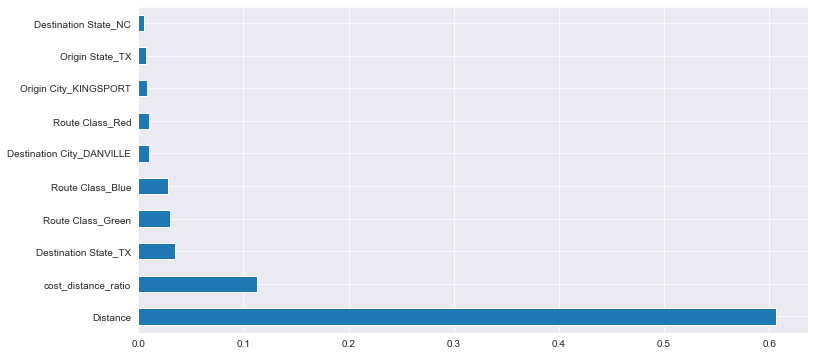

In [558]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

## 1.Algo-1=Applying Linear Regression

In [559]:
from sklearn.feature_selection import RFE
import statsmodels.api as sm
X=outlierremoved_catdummies_data.drop('Cost',axis=1)
X= sm.add_constant(X)
y=outlierremoved_catdummies_data['Cost']

C:\Users\v_v\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [560]:
X.head()

,const,Priority,Distance,cost_distance_ratio,Origin City_ANNISTON,Origin City_ARGO,Origin City_BAYPORT,Origin City_BISHOP,Origin City_BROWNSVILLE,Origin City_CHARLESTON,...,Destination State_SC,Destination State_TN,Destination State_TX,Destination State_UT,Destination State_VA,Destination State_WI,Destination State_WV,Route Class_Blue,Route Class_Green,Route Class_Red
0,1.0,1,-0.024993,-0.141700,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1.0,1,-0.090686,-0.081687,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,1.0,2,-0.367050,-0.113246,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,1.0,1,-0.473519,-0.063517,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,1.0,1,-1.322999,0.590567,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [561]:
#Feature Importance
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

# scaler=StandardScaler()
# ### fit vs fit_transform
# X_train_scaled=scaler.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [562]:
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from sklearn.metrics import r2_score
#fit OLS model

lm_sm=sm.OLS(y_train,X_train).fit()
#making predictions
y_pred_train=lm_sm.predict(X_train)
y_pred_test=lm_sm.predict(X_test)

#evlaution metrics

#R-sqaure
train_r2=lm_sm.rsquared
test_r2=r2_score(y_pred_test, y_test)

#RMSE/stan. error
error_test=y_pred_test-y_test
error_train=y_pred_train-y_train
    
test_RMSE=(((error_test**2).mean())**0.5)
train_RMSE=(((error_train**2).mean())**0.5)

print('----------------------R-sqaure-------------------------------------------')
print("R-sq for test data is {}".format(test_r2))
print("R-sq for train data is {}".format(train_r2))


print('----------------------STANDARD ERROR/RMSE-------------------------------------------')
print("RMSE for test data is {}".format(test_RMSE))
print("RMSE for train data is {}".format(train_RMSE))

print(lm_sm.summary())

----------------------R-sqaure-------------------------------------------
R-sq for test data is 0.5576765813915374
R-sq for train data is 0.9587473322635821
----------------------STANDARD ERROR/RMSE-------------------------------------------
RMSE for test data is 0.6519037648106745
RMSE for train data is 0.2005636918947625
                            OLS Regression Results                            
Dep. Variable:                   Cost   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     8.134
Date:                Mon, 20 Jun 2022   Prob (F-statistic):           3.12e-15
Time:                        12:40:51   Log-Likelihood:                 40.728
No. Observations:                 217   AIC:                             240.5
Df Residuals:                      56   BIC:                             784.7
Df Model:                         160      

## Obervations of linear regresion- not good at all to fit 280 columns

## 2.Applying Linear Regression #Applying for 10 columns 

In [609]:
cols=['Distance','cost_distance_ratio','Route Class_Green','Route Class_Blue','Destination State_TX','Origin City_KINGSPORT','Destination City_READING','Destination City_DANVILLE','Destination State_WV','Route Class_Red']

In [610]:
X=outlierremoved_catdummies_data[cols]
X= sm.add_constant(X)
y=outlierremoved_catdummies_data['Cost']

C:\Users\v_v\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [611]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [612]:
from sklearn.feature_selection import RFE
import statsmodels.api as sm
#fit OLS model
lm_sm=sm.OLS(y_train,X_train).fit()
#making predictions
y_pred_train=lm_sm.predict(X_train)
y_pred_test=lm_sm.predict(X_test)

#evlaution metrics

#R-sqaure
train_r2=lm_sm.rsquared
test_r2=r2_score(y_pred_test, y_test)

#RMSE/stan. error
error_test=y_pred_test-y_test
error_train=y_pred_train-y_train
    
test_RMSE=(((error_test**2).mean())**0.5)
train_RMSE=(((error_train**2).mean())**0.5)

print('----------------------R-sqaure-------------------------------------------')
print("R-sq for test data is {}".format(test_r2))
print("R-sq for train data is {}".format(train_r2))


print('----------------------STANDARD ERROR/RMSE-------------------------------------------')
print("RMSE for test data is {}".format(test_RMSE))
print("RMSE for train data is {}".format(train_RMSE))

print(lm_sm.summary())

----------------------R-sqaure-------------------------------------------
R-sq for test data is 0.4424614600363158
R-sq for train data is 0.7612392265538972
----------------------STANDARD ERROR/RMSE-------------------------------------------
RMSE for test data is 0.6586159809771478
RMSE for train data is 0.4825116287045195
                            OLS Regression Results                            
Dep. Variable:                   Cost   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     82.90
Date:                Mon, 20 Jun 2022   Prob (F-statistic):           1.80e-60
Time:                        13:28:40   Log-Likelihood:                -149.77
No. Observations:                 217   AIC:                             317.5
Df Residuals:                     208   BIC:                             348.0
Df Model:                           8      

## Observations of X having 10 imp variables

## 3.Applying  Linear Regression by removing 'Distance' Variable to see its effect of other X varaibles

In [613]:
cols3=['Route Class_Green','cost_distance_ratio','Route Class_Blue','Destination State_TX','Origin City_KINGSPORT','Destination City_READING','Destination City_DANVILLE','Destination State_WV','Route Class_Red']

In [614]:
X=outlierremoved_catdummies_data[cols3]
X= sm.add_constant(X)
y=outlierremoved_catdummies_data['Cost']

C:\Users\v_v\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [615]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [616]:
from sklearn.feature_selection import RFE
import statsmodels.api as sm
#fit OLS model
lm_sm=sm.OLS(y_train,X_train).fit()
#making predictions
y_pred_train=lm_sm.predict(X_train)
y_pred_test=lm_sm.predict(X_test)

#evlaution metrics

#R-sqaure
train_r2=lm_sm.rsquared
test_r2=r2_score(y_pred_test, y_test)

#RMSE/stan. error
error_test=y_pred_test-y_test
error_train=y_pred_train-y_train
    
test_RMSE=(((error_test**2).mean())**0.5)
train_RMSE=(((error_train**2).mean())**0.5)

print('----------------------R-sqaure-------------------------------------------')
print("R-sq for test data is {}".format(test_r2))
print("R-sq for train data is {}".format(train_r2))


print('----------------------STANDARD ERROR/RMSE-------------------------------------------')
print("RMSE for test data is {}".format(test_RMSE))
print("RMSE for train data is {}".format(train_RMSE))

print(lm_sm.summary())

----------------------R-sqaure-------------------------------------------
R-sq for test data is -9.21510442169565
R-sq for train data is 0.21291235013760612
----------------------STANDARD ERROR/RMSE-------------------------------------------
RMSE for test data is 1.0134333266224693
RMSE for train data is 0.8760680558445185
                            OLS Regression Results                            
Dep. Variable:                   Cost   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     8.077
Date:                Mon, 20 Jun 2022   Prob (F-statistic):           1.09e-08
Time:                        13:29:11   Log-Likelihood:                -279.20
No. Observations:                 217   AIC:                             574.4
Df Residuals:                     209   BIC:                             601.4
Df Model:                           7      

## Observations: It is clearly evident that Distance Variable contributes to the highest level in finding Shipping Cost

## 4.Applying Linear Regression #Applying for 4 columns 

In [617]:
cols4=['Distance','cost_distance_ratio','Destination State_TX','Route Class_Green','Route Class_Blue']

In [618]:
X=outlierremoved_catdummies_data[cols4]
X= sm.add_constant(X)
y=outlierremoved_catdummies_data['Cost']

C:\Users\v_v\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [619]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [620]:
from sklearn.feature_selection import RFE
import statsmodels.api as sm
#fit OLS model
lm_sm=sm.OLS(y_train,X_train).fit()
#making predictions
y_pred_train=lm_sm.predict(X_train)
y_pred_test=lm_sm.predict(X_test)

#evlaution metrics

#R-sqaure
train_r2=lm_sm.rsquared
test_r2=r2_score(y_pred_test, y_test)

#RMSE/stan. error
error_test=y_pred_test-y_test
error_train=y_pred_train-y_train
    
test_RMSE=(((error_test**2).mean())**0.5)
train_RMSE=(((error_train**2).mean())**0.5)

print('----------------------R-sqaure-------------------------------------------')
print("R-sq for test data is {}".format(test_r2))
print("R-sq for train data is {}".format(train_r2))


print('----------------------STANDARD ERROR/RMSE-------------------------------------------')
print("RMSE for test data is {}".format(test_RMSE))
print("RMSE for train data is {}".format(train_RMSE))

print(lm_sm.summary())

----------------------R-sqaure-------------------------------------------
R-sq for test data is 0.41505762723680517
R-sq for train data is 0.7346192459655342
----------------------STANDARD ERROR/RMSE-------------------------------------------
RMSE for test data is 0.6857805646265035
RMSE for train data is 0.5086991451106374
                            OLS Regression Results                            
Dep. Variable:                   Cost   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     116.8
Date:                Mon, 20 Jun 2022   Prob (F-statistic):           8.68e-59
Time:                        13:29:30   Log-Likelihood:                -161.24
No. Observations:                 217   AIC:                             334.5
Df Residuals:                     211   BIC:                             354.8
Df Model:                           5     

### Testing Multi collinearity

In [622]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# the independent variables set
X = outlierremoved_catdummies_data[cols]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                     feature       VIF
0                   Distance  1.336285
1        cost_distance_ratio  1.158333
2          Route Class_Green  1.231446
3           Route Class_Blue  1.899828
4       Destination State_TX  1.160859
5      Origin City_KINGSPORT  1.017997
6   Destination City_READING  1.022658
7  Destination City_DANVILLE  1.009698
8       Destination State_WV  1.014014
9            Route Class_Red  1.523915


## Observations on Multi collinearity== As VIF is <2..So no Multi collinearity in X

## Below graph is for  LR training data Actuals VS Predictions

Text(0, 0.5, 'Ship Cost')

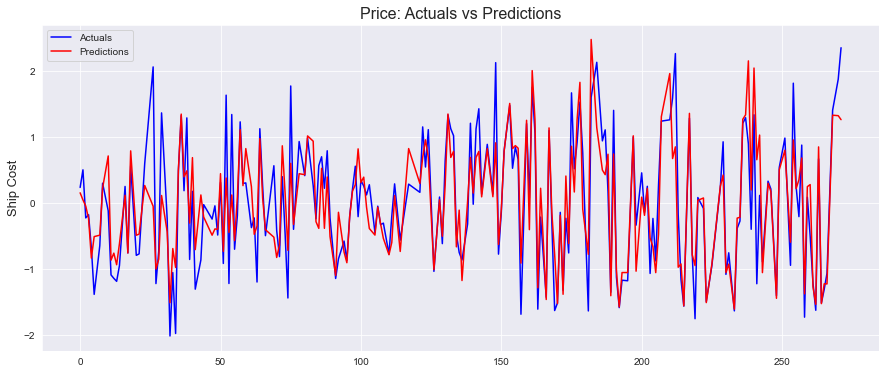

In [623]:
fig, ax=plt.subplots(figsize=(15,6))
sns.lineplot(x=y_train.index,y=y_train,label='Actuals',color='blue',ax=ax)
sns.lineplot(x=y_train.index,y=y_pred_train,label='Predictions',color='red',ax=ax)
ax.set_title('Price: Actuals vs Predictions', fontsize=16)
ax.set_ylabel('Ship Cost',fontsize=13)

## Below graph is for  LR training data Actuals VS Predictions

Text(0, 0.5, 'Ship Cost')

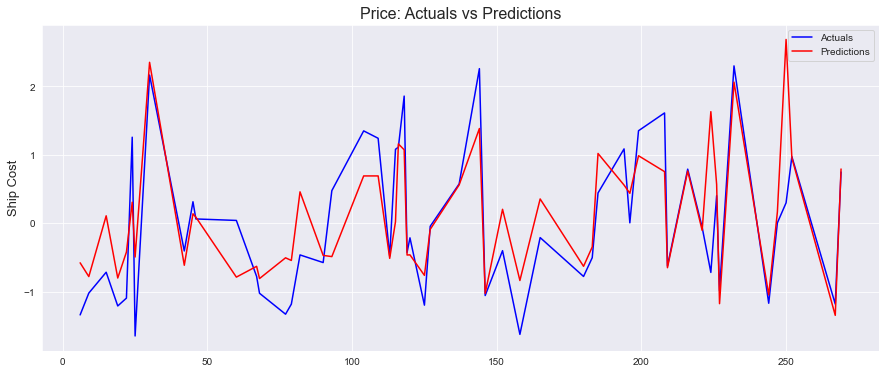

In [624]:
fig, ax=plt.subplots(figsize=(15,6))
sns.lineplot(x=y_test.index,y=y_test,label='Actuals',color='blue',ax=ax)
sns.lineplot(x=y_test.index,y=y_pred_test,label='Predictions',color='red',ax=ax)
ax.set_title('Price: Actuals vs Predictions', fontsize=16)
ax.set_ylabel('Ship Cost',fontsize=13)

### <b> Above Graph shows predictions miss the actual values at some places but given that we want to avoid overfitting and want our model to generalize well and perform well on unseen test data we will have to compromise a bit (bias-variance tradeoff)

#  Linear Regression Assumptions Validation

## Checking Assumptions for Linear Regression model

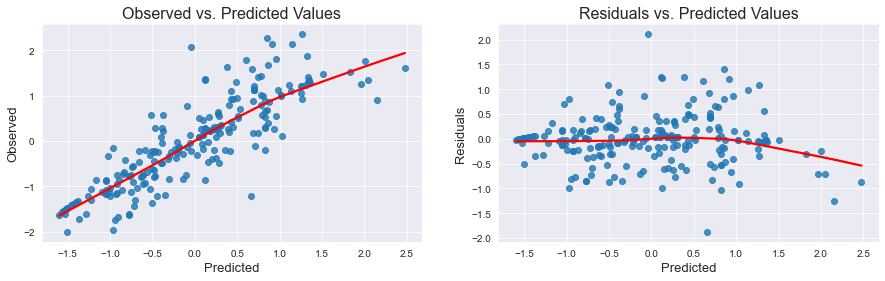

In [625]:
#To detect linearity lets inspect plots of observed vs. predicted values or residuals vs. predicted values. 
#The desired outcome is that points are symmetrically distributed around a diagonal line in the former plot & 
#around horizontal line in the latter one

def linearity_test(model, y):
    
    fitted_vals = model.predict()
    residuals = model.resid
    
    sns.set_style('darkgrid')
    fig,ax=plt.subplots(1,2, figsize=(15,4))
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set_xlabel('Predicted', fontsize=13)
    ax[0].set_ylabel('Observed', fontsize=13)
    
    sns.regplot(x=fitted_vals,y=residuals,lowess=True,ax=ax[1],line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set_xlabel('Predicted', fontsize=13)
    ax[1].set_ylabel('Residuals', fontsize=13)
    
linearity_test(lm_sm, y_train)
#Residuals more or less evenly scattered vs predicted values-looks fine

<b> From above graphs <b>:
    
    1. Obs vs predicted  shows that most of the values are closer to the daigonal line, however some are not which 
       is a problem
       
    2. Resi vs pred graph does not give a conclusive evidence that residuals are evenly scattered around the zero line as            Resi. values increase with increase in predicted values, SO ASSUMPTION OF LINEARITY CAN'T BE CONFIRMED. 
    
    #Residuals more or less evenly scattered vs predicted values-looks fine


# 2. Homoscedasticity (equal variance) of residuals

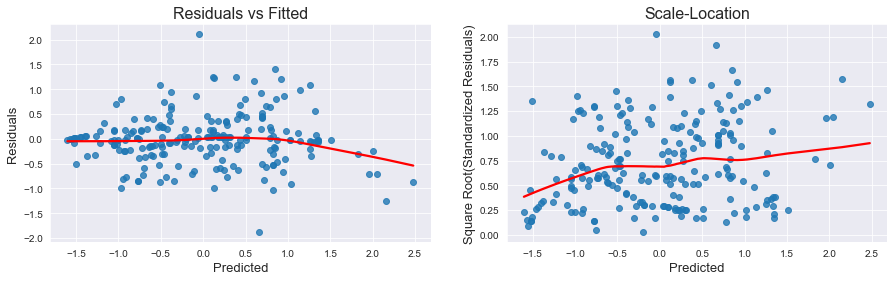

In [626]:
#Homoscedasticity-the variance of the error term must be the same across all levels of independent variables.
#This assumption can be tested by visual inspection of a standardized residual plot by the standardized regression 
#predicted value. Ideally, when the residuals are evenly scattered around the horizontal line, there is presence 
#of homoscedasticity; and when the residuals are not evenly scattered around the horizontal line and takes a various 
#shape like a bowtie, funnel shape, etc., then there is the presence of heteroscedasticity.
 
import statsmodels.stats.api as sms

def homoscedasticity_test(model):
    
    fitted_vals = model.predict()
    residuals = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal
    
    sns.set_style('darkgrid')
    
    
    fig, ax = plt.subplots(1,2,figsize=(15,4))

    sns.regplot(x=fitted_vals, y=residuals, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set_xlabel('Predicted', fontsize=13)
    ax[0].set_ylabel('Residuals', fontsize=13)

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set_xlabel('Predicted', fontsize=13)
    ax[1].set_ylabel('Square Root(Standardized Residuals)', fontsize=13)

      
homoscedasticity_test(lm_sm)
#both graphs show evenly spread residuals so homoscedasticity is present

C:\Users\v_v\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


Jarque-Bera test ---- statistic: 36.5339, p-value: 1.1661709709009926e-08
Shapiro-Wilk test ---- statistic: 0.9612, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.1889, p-value: 0.0000
Anderson-Darling test ---- statistic: 3.2124, 5% critical value: 0.7730
If the returned Anderson Draling statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


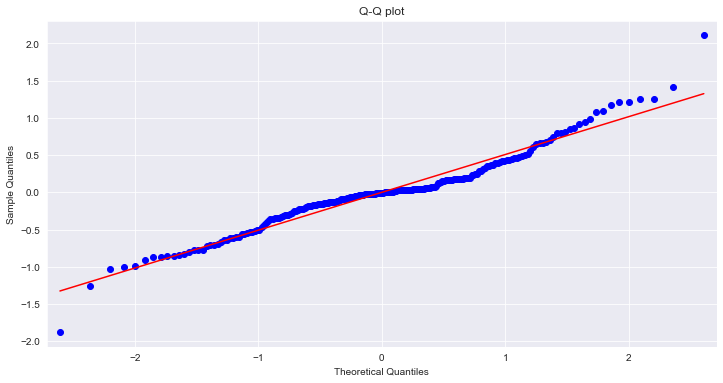

In [627]:
from scipy import stats

def normality_of_residuals_test(model):
    '''
    Function for drawing the normal QQ-plot of the residuals and running 4 statistical tests to 
    investigate the normality of residuals.
    
    Arg:
    * model - fitted OLS models from statsmodels
    '''
    
    sm.ProbPlot(model.resid).qqplot(line='s');
    plt.title('Q-Q plot');
    

    jb = stats.jarque_bera(model.resid)
    sw = stats.shapiro(model.resid)
    ad = stats.anderson(model.resid, dist='norm')
    ks = stats.kstest(model.resid, 'norm')
    
    print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
    print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
    print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
    print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
    print('If the returned Anderson Draling statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. ')
    
normality_of_residuals_test(lm_sm)

#Q-Q plot shows residuals is mostly normal except at upper tail

#Since normality is not a strict assumption and close to normal distribution is fine, its safe to ignore the upper tail

#https://stats.stackexchange.com/questions/152674/why-is-the-normality-of-residuals-barely-important-at-all-for-the-purpose-of-e

<b> Normality of errors not satisifed as:
    1. Q-Q Plot shows deviation from normal distirbution esp at tails
    2. P-value in first 3 normality tests<0.05 and Anderson-Darling statistic>AD critical value, thus null hypo that 
    errors have normal dist is rejected


In [628]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_test))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_test))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

MAE: 0.47346215547782816
MSE: 0.47029498281944593
RMSE: 0.6857805646265035


## 2)Algo-2= Fitting model using Random Forest Regressor

1. Split dataset into train and test set in order to prediction w.r.t X_test
2. If needed do scaling of data
    * Scaling is not done in Random forest
3. Import model
4. Fit the data
5. Predict w.r.t X_test
6. In regression check **RSME** Score
7. Plot graph

In [630]:
## Not needed for any feature scaling for Decisison tree algorithms

In [662]:
cols4

['Distance',
 'cost_distance_ratio',
 'Destination State_TX',
 'Route Class_Green',
 'Route Class_Blue']

In [672]:
X=outlierremoved_catdummies_data[cols4]
#X=outlierremoved_catdummies_data.drop('Cost',axis=1)
y=outlierremoved_catdummies_data['Cost']

In [673]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [674]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor()
reg_rf.fit(X_train, y_train)

RandomForestRegressor()

In [675]:
y_pred = reg_rf.predict(X_test)

In [676]:
reg_rf.score(X_train, y_train)

0.990138260635678

In [677]:
reg_rf.score(X_test, y_test)

0.9024821531051906

In [678]:
predictions=reg_rf.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.2283539026957852
MSE: 0.10707859591186236
RMSE: 0.32722865997932143


## ## 3)Algo-2= Fitting model using Random Forest Regressor with cv and Hyper parameter

## Hyperparameter Tuning


* Choose following method for hyperparameter tuning
    1. **RandomizedSearchCV** --> Fast
    2. **GridSearchCV**
* Assign hyperparameters in form of dictionery
* Fit the model
* Check best paramters and best score

In [685]:
X=outlierremoved_catdummies_data[cols4]
#X=outlierremoved_catdummies_data.drop('Cost',axis=1)
y=outlierremoved_catdummies_data['Cost']

In [686]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [687]:
# Decision tree and Random forrest doesnot need standard scaling 
from sklearn.ensemble import RandomForestRegressor
#rf_random= RandomForestRegressor()

In [688]:
#Hyperparameters tuning using Gridsearchcv and 5old cross validation
import numpy as np
n_estimators= [int(x) for x in np.linspace(100,1200,num=12) ]
print(n_estimators)

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]


In [689]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

 #Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [690]:
# Create the random grid using key value pair
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [691]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)#,scoring='neg_mean_squared_error'
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   1.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   1.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   1.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   1.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   1.6s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   1.8s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   1.5s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimator

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, verbose=2)

In [692]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 25}

In [693]:
rf_random.score(X_train, y_train)

0.9842619792986158

In [694]:
rf_random.score(X_test,y_test)

0.8872372927823002

In [695]:
predictions=rf_random.predict(X_test)

C:\Users\v_v\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Cost', ylabel='Density'>

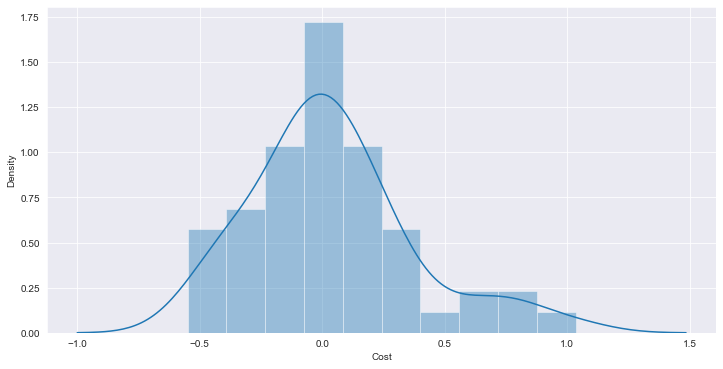

In [696]:
sns.distplot(y_test-predictions)
#Gausiian distributino graph:diff of MSE between actual and predicted is between -2 to 2

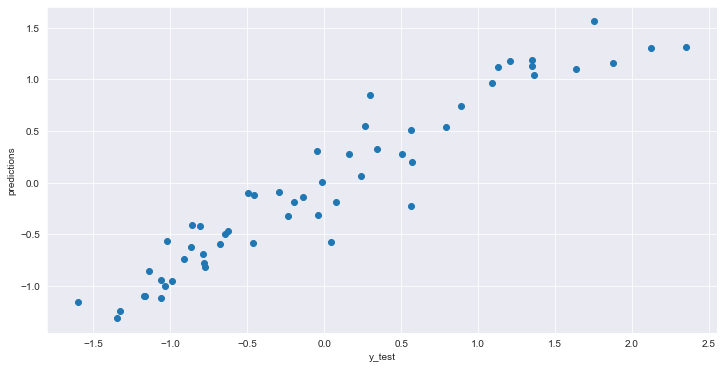

In [697]:
plt.scatter(y_test,predictions)
plt.xlabel("y_test")
plt.ylabel("predictions")
plt.show()

In [698]:
from sklearn import metrics

In [699]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.24146667477618558
MSE: 0.11110825818978944
RMSE: 0.3333290539238808


import pickle
# open a file, where you want to store the data
file=open("kushwanthreandomforrestregressor.pkl","wb")
# dump information to that file
pickle.dump(rf_random,file)
!pip freeze requirements.txt  

model = open('flight_price_rf.pkl','rb')
forest = pickle.load(model)

y_prediction = forest.predict(X_test)
metrics.r2_score(y_test, y_prediction)

## References
    
https://statisticsbyjim.com/regression/overfitting-regression-models/

https://medium.com/@emredjan/emulating-r-regression-plots-in-python-43741952c034

https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0

https://dziganto.github.io/cross-validation/data%20science/machine%20learning/model%20tuning/python/Model-Tuning-with-Validation-and-Cross-Validation/
    